In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.display import IFrame
import folium
import json
import math
import sklearn

from branca.colormap import LinearColormap, StepColormap, linear
from branca.element import MacroElement
from jinja2 import Template
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import SpectralClustering
from sklearn import mixture

from mpl_toolkits.mplot3d import Axes3D

from functools import partial

## TOOLS

### General tables

* <u> FIPS Country codes </u> 
    <br>
In order to link the different datasets based on geographical locations information, we translate Country names into their corresponding FIPS code and vice versa :

In [2]:
FIPS_codes = pd.read_csv('Data/fipscountries.csv', usecols = ['country', 'fips'])\
    .rename(index=str, columns={'fips':'FIPS'})\
    .rename(index=str, columns={'country':'Country'})
FIPS_codes.head()

,FIPS,Country
0,AN,Andorra
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AC,Antigua and Barbuda
4,AV,Anguilla


* <u> CAMEO Code</u> <br>
This dictionnary contains the correspondance between each `EventCode` (or `EventRootCode`) and its textual description. These codes are used in the GDELT dataset to describe each event and there signification can be found at  [CAMEO](https://www.gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf)


In [3]:
CAMEO_translation = pd.read_csv('Data/CAMEO_code', header=None, sep=':', names=['Code', 'Translation'], dtype={'Code': np.str})
CAMEO_translation.set_index('Code',inplace=True)
CAMEO_translation_dict = CAMEO_translation['Translation'].to_dict()
CAMEO_translation.head()

,Translation
Code,
01,MAKE PUBLIC STATEMENT
010,"Make statement, not specified below"
011,Decline comment
012,Make pessimistic comment
013,Make optimistic comment


* <u> Happiness score Dataset </u> <br>
This dataset is obtained from the World Happiness Report (2018). We extract only the columns of interest for studies related to the Happiness score:

In [4]:
happinessData = pd.read_excel('Data/HappinessData.xls', sheet_name = 'Figure2.2', usecols="A,B")

# Renaming certain countries for uniformity reasons
happinessData.loc[happinessData['Country']=='Congo (Brazzaville)', 'Country'] = 'Republic of the Congo'
happinessData.loc[happinessData['Country']=='Congo (Kinshasa)', 'Country'] = 'Democratic Republic of the Congo'
    
happinessData= happinessData.merge(FIPS_codes, left_on='Country', right_on='Country') # merging with FIPS_codes in order to make the link with country names
happinessData.head()

,Country,Happiness score,FIPS
0,Finland,7.6321,FI
1,Norway,7.5937,NO
2,Denmark,7.5553,DA
3,Iceland,7.4952,IC
4,Switzerland,7.4873,SZ


* <u> Confidence in the government dataset</u> <br>
This dataset is also obtained from the World Report (2018). Note that we keep only the more recent value for each country.

In [5]:
corruptionData = pd.read_excel('Data/HappinessData.xls', sheet_name = 'Table2.1', usecols="A,B, I")\
                            .dropna()\
                            .sort_values('year', ascending=False) \
                            .groupby("country") \
                            .first()\
                            .rename(index=str, columns={'year':'year_corruption'})
corruptionData.head()

,year_corruption,Perceptions of corruption
country,,
Afghanistan,2017,0.954393
Albania,2017,0.876135
Algeria,2017,0.699774
Angola,2014,0.834076
Argentina,2017,0.841052


* <u>Perception of corruption </u> <br>
This dataset is also obtained from the World Report (2018). Note that we keep only the more recent value for each country.

In [6]:
confidenceInGovernment = pd.read_excel('Data/HappinessData.xls', sheet_name = 'Table2.1', usecols="A,B, L")\
                            .dropna()\
                            .sort_values('year', ascending=False) \
                            .groupby("country") \
                            .first()\
                            .rename(index=str, columns={'year':'year_confidence'})
confidenceInGovernment.head()

,year_confidence,Confidence in national government
country,,
Afghanistan,2017,0.261179
Albania,2017,0.457738
Angola,2014,0.572346
Argentina,2017,0.305430
Armenia,2017,0.246901


* <u> Democratic quality </u> <br>
This dataset is obtained from The Economist Intelligence Unit [Democracy index](http://pages.eiu.com/rs/753-RIQ-438/images/Democracy_Index_2017.pdf?mkt_tok=eyJpIjoiWkRKbU1HWmxNVEUwTW1FdyIsInQiOiJPdlltVFV0blFRQzZNVERCZHhVeitZRElmUGplOHh3NWs1d2wzVzdRS1JvNU1kVmUxQVRESU9LbEVSOVwvR1F4aG1PV1NlS0ZZcng4NzBcLzVNZ09JOUxiZU5TTEVPekVHayttOTRqQkQ5TkNzWGN08RlowQTZ0UzlUK0pDdm9PVGlcLyJ9) :


In [7]:
DemocraticQualityData = pd.read_csv('Data/democracy_index.csv', usecols=['Country', 'Score', 'Category'])\
    .rename(index=str, columns={'Score':'Democratic Quality'})\
    .merge(FIPS_codes, left_on='Country', right_on='Country') # Merging with the FIPS codes because it is originally based on country names

DemocraticQualityData.head()

,Country,Democratic Quality,Category,FIPS
0,Norway,9.87,Full democracy,NO
1,Iceland,9.58,Full democracy,IC
2,Sweden,9.39,Full democracy,SW
3,New Zealand,9.26,Full democracy,NZ
4,Denmark,9.22,Full democracy,DA


### Useful functions

In [8]:
def color_function(feature, data, color_fun):
    # color function used for mapping
    value = data.get(feature['properties']['name'])
    if value is None:
        return '#8c8c8c' # MISSING VALUES -> gray
    else:
        return color_fun(value)

In [9]:
def bootstrapping(data, number_of_sample, features, t=1.96):
    # bootstrapping function in order to assess a population statistic, based on a sample of this population
    # in this case, the statistic computed is the correlation between 2 features
    # this function also computes the confidence interval of this correlation
    feature1 = features[0]
    feature2 = features[1]
    r = []
    sample_size = len(data)
    for i in range(number_of_sample):
        rnd_idx = np.random.randint(0, len(data), size=sample_size)
        data_sampled = data.iloc[rnd_idx]
        pearson_coeff = sp.stats.pearsonr(data_sampled[feature1], data_sampled[feature2])[0]
        # if the sample contains only identical values, the std is zero and pearsonr return NaN because of 
        # an impossible division by zero
        if not math.isnan(pearson_coeff):
            r.append(pearson_coeff)
     
    r_mean = np.mean(r) 
    z = np.log((1+r_mean)/(1-r_mean))/2
    std_err = 1/np.sqrt(sample_size-3)
    lower_z = z - std_err*t
    upper_z = z + std_err*t
    
    lower_r = (np.exp(2*lower_z)-1)/(np.exp(2*lower_z)+1)
    upper_r = (np.exp(2*upper_z)-1)/(np.exp(2*upper_z)+1)
    CI = (lower_r, upper_r)
    return r , CI

# Overall analysis : first glance

We used the dataset of GDELT V2 available on the google [BigQuerry](https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events) service. 

To be able to study the representation of one country by the media of another, we decided join the Mention and the Event. From the first one we retrive the tone (*MentionDocTone*) of the mention and the location of the source, based on *source_by_country*. From the latter we get the [CAMEO](https://www.gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf) code and the location of the event.

To identify the country of the source, we used the table *source_by_country.csv*  provided on the [GDELT blog](https://blog.gdeltproject.org/mapping-the-media-a-geographic-lookup-of-gdelts-sources/).

In [10]:
source_by_country = pd.read_csv('Data/sources_by_country.csv', sep='\t')
source_by_country.head()

,url,FIPS,Country
0,0-100.it,IT,Italy
1,0-50.ru,RS,Russia
2,0-60mag.com,US,United States
3,0-debt.com,US,United States
4,000fff.org,US,United States


The SQL query to retrieve the main table is:

SELECT EventCode, EventRootCode, LocMention, ActionGeo_CountryCode AS LocEvent, AVG(MentionDocTone) as AverageTone, COUNT(*) as NumberOfInterMentions

FROM (

    SELECT GLOBALEVENTID AS GLOBALEVENTID_mentions , MentionSourceName, MentionDocTone, FIPSCode AS LocMention 
    
    FROM `gdelt-bq.gdeltv2.eventmentions` 
    
    INNER JOIN `ada-projet-2018.gdeltv2.sources_by_country` ON MentionSourceName = MentionSource 
      
    WHERE MentionType = 1 
    
    ) 
    
INNER JOIN `gdelt-bq.gdeltv2.events` ON `gdelt-bq.gdeltv2.events`.GLOBALEVENTID = GLOBALEVENTID_mentions 

GROUP BY EventCode, LocMention, ActionGeo_CountryCode

*Let's see what it's all about*

We will first create the tables useful for our analysis. 

In [11]:
output_intercountry_tone_count = pd.read_csv('Data/intercountry_tone_count_table_with_EVENTCODE',\
                              dtype={'EventRootCode': np.str, 'EventCode': np.str})
output_intercountry_tone_count.head()

,EventRootCode,EventCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
0,02,021,BH,GY,-2.748098,2
1,13,131,FI,CA,-0.865801,1
2,08,085,NE,SW,-0.535016,11
3,18,183,SM,SY,-4.294479,1
4,17,170,LH,BO,-3.949045,1


**Table for geography**

In [12]:
fips_codes = pd.read_csv('Data/fipscountries.csv')
fips_to_country_dict = fips_codes.set_index('fips')['country'].to_dict()
fips_codes.head()

,iso,iso3,iso_numeric,fips,country,capital,area,population,continent,tld,currency_code,currency_name,phone,postal_code_format,postal_code_regex,languages,geonameid,neighbours,equivalent_fips_code
0,AD,AND,20,AN,Andorra,Andorra la Vella,468.0,84000,EU,.ad,EUR,Euro,376,AD###,^(?:AD)*(\d{3})$,ca,3041565.0,"ES,FR",NaN
1,AE,ARE,784,AE,United Arab Emirates,Abu Dhabi,82880.0,4975593,AS,.ae,AED,Dirham,971,NaN,NaN,"ar-AE,fa,en,hi,ur",290557.0,"SA,OM",NaN
2,AF,AFG,4,AF,Afghanistan,Kabul,647500.0,29121286,AS,.af,AFN,Afghani,93,NaN,NaN,"fa-AF,ps,uz-AF,tk",1149361.0,"TM,CN,IR,TJ,PK,UZ",NaN
3,AG,ATG,28,AC,Antigua and Barbuda,St. John's,443.0,86754,NaN,.ag,XCD,Dollar,+1-268,NaN,NaN,en-AG,3576396.0,NaN,NaN
4,AI,AIA,660,AV,Anguilla,The Valley,102.0,13254,NaN,.ai,XCD,Dollar,+1-264,NaN,NaN,en-AI,3573511.0,NaN,NaN


### Data cleaning

The first step is to manage the unwanted values in the different fields.

In [13]:
output_intercountry_tone_count.describe()

,AverageTone,NumberOfInterMentions
count,2.276624e+06,2.276624e+06
mean,-3.054588e+00,5.436779e+02
std,3.004094e+00,4.150633e+04
min,-3.000612e+01,1.000000e+00
25%,-4.929183e+00,2.000000e+00
50%,-2.995903e+00,7.000000e+00
75%,-1.150335e+00,3.500000e+01
max,1.925926e+01,2.763939e+07


No incoherent numerical values. Let's check the other columns. 

In [14]:
print("Number of unique countries of event location : {}".format(output_intercountry_tone_count.LocEvent.unique().size))
print("Number of unique countries of mention location : {}".format(output_intercountry_tone_count.LocMention.unique().size))

Number of unique countries of event location : 263
Number of unique countries of mention location : 233


As we can see, there are a lot of different location, more than the number of countries counted by the UN. 

In [15]:
print("Number of NaN values for the Event Location : {}".format(output_intercountry_tone_count.LocEvent.isna().sum()))
print("Number of NaN values for the Mention Location : {}".format(output_intercountry_tone_count.LocMention.isna().sum()))

Number of NaN values for the Event Location : 31319
Number of NaN values for the Mention Location : 0


In [16]:
output_intercountry_tone_count.EventRootCode.unique()

array(['02', '13', '08', '18', '17', '03', '10', '11', '12', '05', '14',
       '16', '15', '04', '20', '09', '19', '06', '07', '01', '--', 'X'],
      dtype=object)

In [17]:
np.sum([(output_intercountry_tone_count['EventRootCode'] == '--') | (output_intercountry_tone_count['EventRootCode'] == 'X')])

30

The data seems to be quite clean. Indeed, event if we have some undesirable values, most of the time we can use the other colums to extract informations. 
Since there is a lot of row containing NaN for the Location of the event, it is a bad idea to drop all of them, since they still contain valuable information. For exemple, the tone of the media for a particular event type. 
Depending on the futur calculations, we will be careful to use only the relevenant rows and columns. 

Now it is time to plot some stuff ! 

## First data analysis

The first step is to get to know a bit better our dataset. So we will compute some general statitics.

The field *NumberOfInterMention* count the number of mention of a country (*LocEvent*) for a particular *EventCode* from the media of a particular country (*LocEvent*).

In [18]:
inter_country = output_intercountry_tone_count.drop(output_intercountry_tone_count[output_intercountry_tone_count.EventRootCode == '--'].index)
inter_country = inter_country.drop(inter_country[inter_country.EventRootCode == 'X'].index)
inter_country.head()

,EventRootCode,EventCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
0,02,021,BH,GY,-2.748098,2
1,13,131,FI,CA,-0.865801,1
2,08,085,NE,SW,-0.535016,11
3,18,183,SM,SY,-4.294479,1
4,17,170,LH,BO,-3.949045,1


In [19]:
group_by_CAMEO_df = output_intercountry_tone_count.drop(output_intercountry_tone_count[output_intercountry_tone_count.EventRootCode == '--'].index)
group_by_CAMEO_df = group_by_CAMEO_df.drop(group_by_CAMEO_df[group_by_CAMEO_df.EventRootCode == 'X'].index)

In [20]:
f_cameo = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=group_by_CAMEO_df.loc[x.index, "NumberOfInterMentions"])}

group_by_CAMEO_df = group_by_CAMEO_df.groupby('EventRootCode').agg(f_cameo)
group_by_CAMEO_df.reset_index(inplace=True)
group_by_CAMEO_df.sort_values('AverageTone')

,EventRootCode,NumberOfInterMentions,AverageTone
17,18,19844822,-6.055350
16,17,56881696,-5.488661
18,19,93718524,-5.224588
19,20,471053,-4.840787
13,14,10909461,-4.024629
10,11,78508904,-3.926067
12,13,18196648,-3.871969
8,09,27571349,-3.360052
15,16,11581139,-3.210676
14,15,3853958,-3.163792


In [21]:
all_mention = group_by_CAMEO_df['NumberOfInterMentions'].sum()
all_mention

1237749864

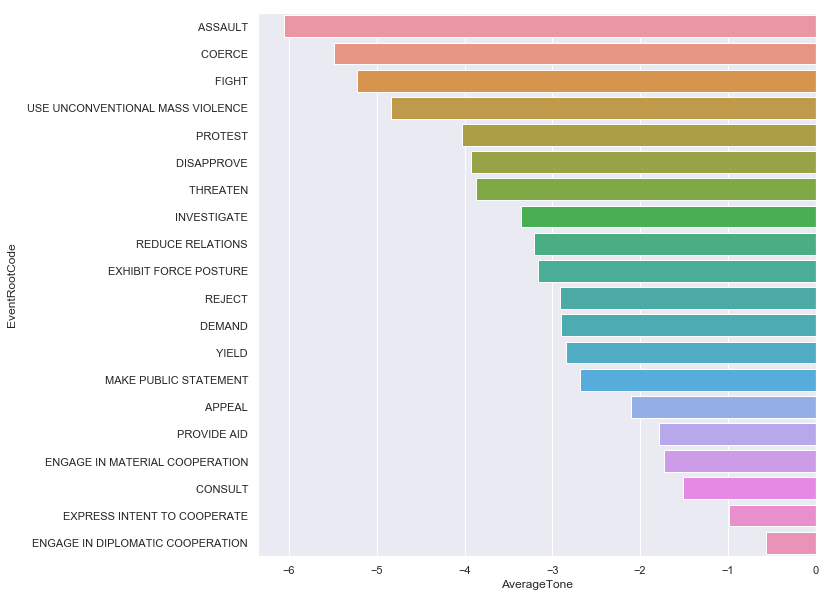

In [22]:
toPlot1 = group_by_CAMEO_df.sort_values(['AverageTone'], ascending=True)
toPlot1 = toPlot1.reset_index(drop=True)
toPlot1['EventRootCode'] = toPlot1['EventRootCode'].replace(CAMEO_translation_dict)
sn.set(rc={'figure.figsize':(10,10)})
ax = sn.barplot( toPlot1.AverageTone, toPlot1.index, orient="h")
ax.set_yticklabels(toPlot1.EventRootCode)
ax.set(xlabel='AverageTone', ylabel='EventRootCode')
fig = ax.get_figure()

At first sight, this graph seems to be coherent with common sense. The more the event is violent or conflictual, the more it get a negative tone.
However, we notice that, indepndetly of the event type, the average tone is always negative. 

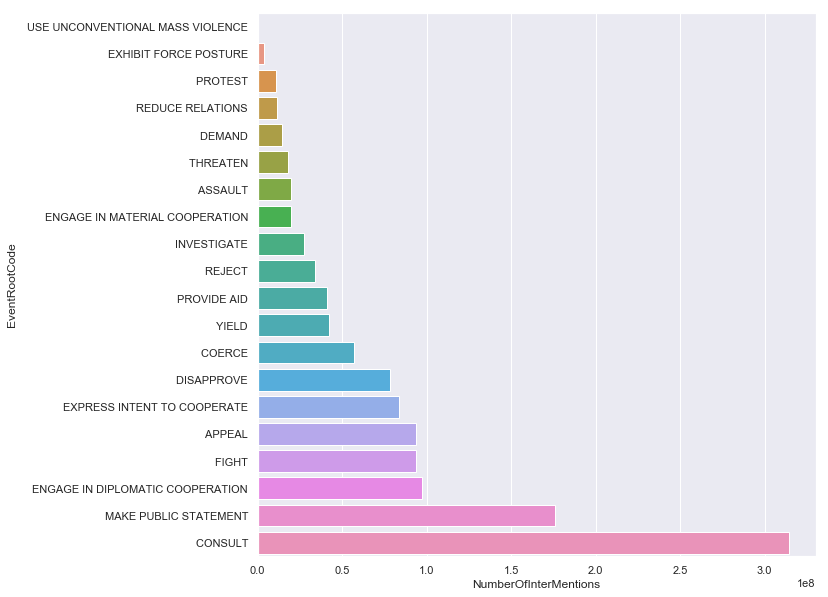

In [23]:
toPlot2 = group_by_CAMEO_df.sort_values(['NumberOfInterMentions'], ascending=True).reset_index(drop=True)
toPlot2['EventRootCode'] = toPlot2['EventRootCode'].replace(CAMEO_translation_dict)
ax = sn.barplot(toPlot2.NumberOfInterMentions, toPlot2.index, orient="h")
ax.set_yticklabels(toPlot2.EventRootCode)
ax.set(xlabel='NumberOfInterMentions', ylabel='EventRootCode')
fig = ax.get_figure()

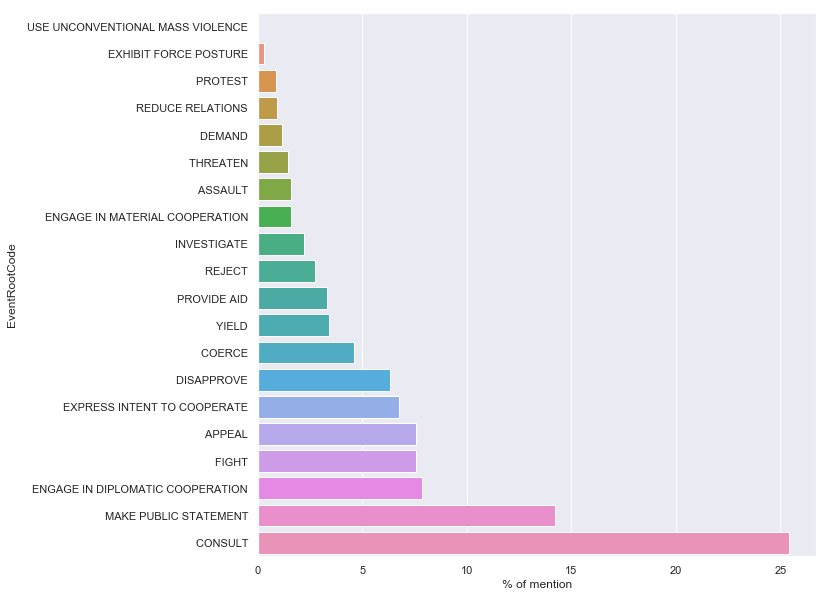

In [24]:
toPlot3 = group_by_CAMEO_df.sort_values(['NumberOfInterMentions'], ascending=True).reset_index(drop=True)
toPlot3['EventRootCode'] = toPlot3['EventRootCode'].replace(CAMEO_translation_dict)
ax = sn.barplot(x='NumberOfInterMentions', y = 'EventRootCode', data=toPlot3, orient="h", estimator= lambda x: x[0]/all_mention * 100 )
ax.set_yticklabels(toPlot3.EventRootCode)
ax.set(xlabel='% of mention', ylabel='EventRootCode')
fig = ax.get_figure()

Here we can see that the most mentionned subject are rather positive. 

In [25]:
country_mentioned = inter_country.groupby('LocMention').sum()['NumberOfInterMentions'].to_frame()
country_mentioned = country_mentioned.reset_index().sort_values(['NumberOfInterMentions'], ascending=False)
country_mentioned.head()

,LocMention,NumberOfInterMentions
216,US,554661940
214,UK,52704265
98,IN,47704266
12,AS,45143640
34,CA,30251136


In [26]:
country_mentioned.describe()

,NumberOfInterMentions
count,2.330000e+02
mean,5.312231e+06
std,3.681846e+07
min,1.300000e+01
25%,4.976800e+04
50%,4.966480e+05
75%,2.157625e+06
max,5.546619e+08


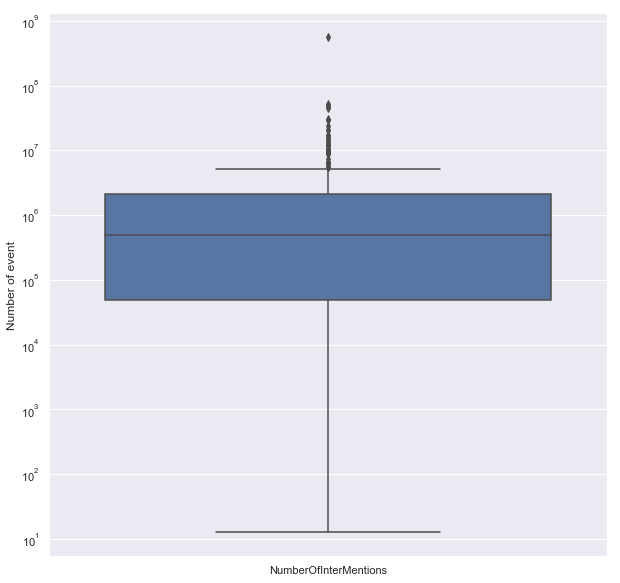

In [27]:
sn.set(rc={'figure.figsize':(10,10)})

ax = sn.boxplot(data=country_mentioned, orient="v")
ax.set(ylabel='Number of event')
ax.set_yscale("log")
fig = ax.get_figure()

There is a huge disparity in the coverage of the different countries. The dataset is mostly composed of mention of event in th US. It comes from the fact that GDELT is based in the USA and a huge part of the sources comes from there. Since news rather talk about local event, USA is mentionned more. 

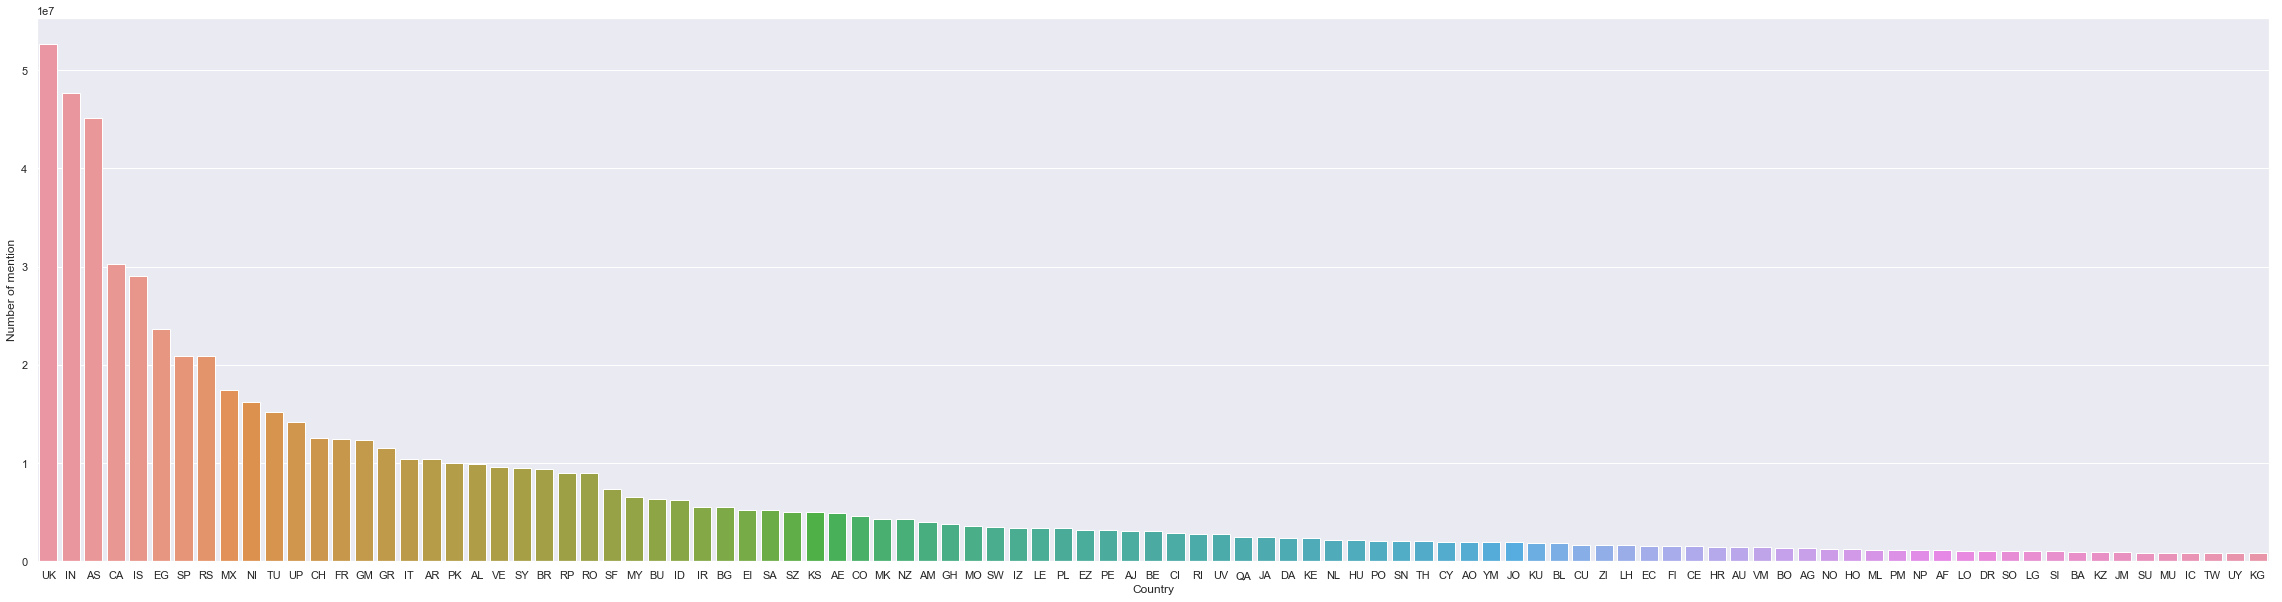

In [28]:
sn.set(rc={'figure.figsize':(40,10)})

ax = sn.barplot(x='LocMention', y = 'NumberOfInterMentions', data=country_mentioned[1:100], orient="v")
ax.set(xlabel='Country', ylabel='Number of mention')
fig = ax.get_figure()

In [29]:
country_event_location = inter_country.groupby('LocEvent').sum()['NumberOfInterMentions'].to_frame()
country_event_location = country_event_location.reset_index().sort_values(['NumberOfInterMentions'], ascending=False)
country_event_location.head()

,LocEvent,NumberOfInterMentions
241,US,355497610
239,UK,47778946
201,RS,46080649
110,IS,35113199
220,SY,30221640


In [30]:
country_event_location.describe()

,NumberOfInterMentions
count,2.620000e+02
mean,4.467980e+06
std,2.281908e+07
min,6.000000e+00
25%,8.373750e+04
50%,6.663635e+05
75%,2.630226e+06
max,3.554976e+08


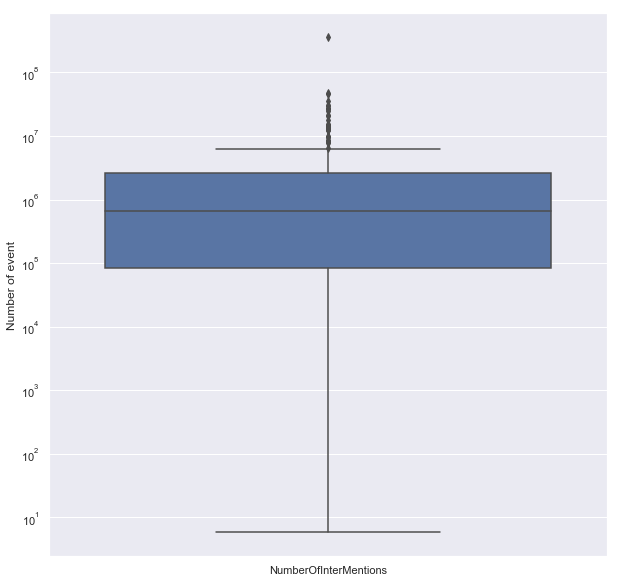

In [31]:
sn.set(rc={'figure.figsize':(10,10)})

ax = sn.boxplot(data=country_event_location, orient="v")
ax.set(ylabel='Number of event')
ax.set_yscale("log")
fig = ax.get_figure()

Since the data set is centered around the US, we will first analyze the reciprocal vision of the world vs the US. 

**How the USA see themself ?**

In [32]:
US_self = inter_country[(inter_country.LocEvent == 'US') & (inter_country.LocMention == 'US')]
US_self.head()

,EventRootCode,EventCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
2187076,10,1034,US,US,-2.926781,8
2187395,15,151,US,US,-3.608795,41461
2187440,12,1243,US,US,-5.699666,90653
2187476,02,0256,US,US,-3.362497,21773
2187492,18,185,US,US,-5.809000,14187


In [33]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=US_self.loc[x.index, "NumberOfInterMentions"])

# Define a dictionary with the functions to apply for a given column:
f1 = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=US_self.loc[x.index, "NumberOfInterMentions"])}

# Groupby and aggregate with your dictionary:
US_self_grpd_CAMEO_wm = US_self.groupby(["EventRootCode"]).agg(f1)   
US_self_grpd_CAMEO_wm.head()

,NumberOfInterMentions,AverageTone
EventRootCode,,
01,48973833,-2.900924
02,24446143,-2.141017
03,17389983,-0.912860
04,66847146,-1.625520
05,21183860,-0.686615


In [34]:
US_self_grpd_all_wm = np.average(US_self_grpd_CAMEO_wm['AverageTone'], weights=US_self_grpd_CAMEO_wm['NumberOfInterMentions'])
print("Average tone of US event seen from the US medias: {}".format(US_self_grpd_all_wm))

Average tone of US event seen from the US medias: -2.7107840310145788


In [35]:
US_self_grpd_all_count =US_self_grpd_CAMEO_wm['NumberOfInterMentions'].sum()
print("Number of mention from the US to themself: {}".format(US_self_grpd_all_count))

Number of mention from the US to themself: 299352671


**How the world see the USA ?**

In [36]:
world_to_US = inter_country[(inter_country.LocEvent == 'US') & (inter_country.LocMention != 'US')]
world_to_US.head()

,EventRootCode,EventCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
5,03,0353,IV,US,-2.439024,1
15,05,056,GV,US,-0.134953,1
49,02,0214,CB,US,-4.250807,24
53,10,1031,HK,US,-2.112676,3
87,02,0231,HA,US,-1.685139,20


In [37]:
# Define a dictionary with the functions to apply for a given column:
f_w_us_cameo = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=world_to_US.loc[x.index, "NumberOfInterMentions"])}
world_to_US_grpd_CAMEO_wm = world_to_US.groupby(["LocMention","EventRootCode"]).agg(f_w_us_cameo)   
world_to_US_grpd_CAMEO_wm.head()

NumberOfInterMentions  AverageTone
LocMention EventRootCode                                    
AA         01                                 4     2.525153
           02                                 1    -1.921470
           03                                 1     5.637467
           04                                 8     3.521914
           05                                 3     4.127487

In [38]:
f_w_us_all = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=world_to_US_grpd_CAMEO_wm.loc[x.index, "NumberOfInterMentions"])}
world_to_US_grpd_all_wm = world_to_US_grpd_CAMEO_wm.groupby('LocMention').agg(f_w_us_all)
world_to_US_grpd_all_wm.head()

,NumberOfInterMentions,AverageTone
LocMention,,
AA,19,3.212118
AC,458,-2.904458
AE,390081,-1.987494
AF,64745,-2.740300
AG,54844,-2.334884


In [39]:
world_to_US_grpd_all_wm= world_to_US_grpd_all_wm.append(pd.Series({'NumberOfInterMentions':US_self_grpd_all_count, 'AverageTone': US_self_grpd_all_wm}, name='US'))\
                        .sort_index()
world_to_US_grpd_all_wm.loc['US']

NumberOfInterMentions    2.993527e+08
AverageTone             -2.710784e+00
Name: US, dtype: float64

We drop we exclude the 10% of the countries mentioning the least the USA.

In [40]:
inter_mention_treshold = world_to_US_grpd_all_wm.NumberOfInterMentions.quantile(0.1)
world_to_US_grpd_all_wm.drop(world_to_US_grpd_all_wm[world_to_US_grpd_all_wm.NumberOfInterMentions < inter_mention_treshold].index, inplace=True)

**How the USA see the world ?**

In [41]:
US_to_world = inter_country[(inter_country.LocEvent != 'US') & (inter_country.LocMention == 'US')]
US_to_world.head()

,EventRootCode,EventCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
2187055,12,122,US,EG,-3.463448,803
2187056,11,113,US,IC,-4.555342,24
2187057,03,0331,US,VI,-0.449159,4
2187058,05,055,US,BR,-4.878324,1255
2187059,02,0232,US,FR,-2.490066,179


In [42]:
# Define a dictionary with the functions to apply for a given column:
f_us_w_cameo = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=US_to_world.loc[x.index, "NumberOfInterMentions"])}
US_to_world_grpd_CAMEO_wm = US_to_world.groupby(["LocEvent","EventRootCode"]).agg(f_us_w_cameo)   
US_to_world_grpd_CAMEO_wm.head()

NumberOfInterMentions  AverageTone
LocEvent EventRootCode                                    
AA       01                              4047    -2.706718
         02                              2239    -4.375275
         03                              1674     0.517300
         04                              9565    -1.781481
         05                              1089     1.635059

In [43]:
f_us_w_all = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=US_to_world_grpd_CAMEO_wm.loc[x.index, "NumberOfInterMentions"])}
US_to_world_grpd_all_wm = US_to_world_grpd_CAMEO_wm.groupby('LocEvent').agg(f_us_w_all)
US_to_world_grpd_all_wm.head()

,NumberOfInterMentions,AverageTone
LocEvent,,
AA,26151,-2.369967
AC,55358,-2.550472
AE,830206,-2.102536
AF,4617405,-4.708119
AG,251174,-4.274587


We drop the 10% of the countries mentionned the least by the USA.

In [44]:
inter_mention_treshold2 = US_to_world_grpd_all_wm.NumberOfInterMentions.quantile(0.1)
US_to_world_grpd_all_wm.drop(US_to_world_grpd_all_wm[US_to_world_grpd_all_wm.NumberOfInterMentions < inter_mention_treshold2].index, inplace=True)


In [177]:
world_borders = json.load(open('Data/world_borders.topojson.json'))
world_map = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

# Defining a style function to color the map and the borders
style_func=lambda feature: {'fillColor': '#990033','color' : 'black','weight' : 2 }

 # Using a GeoJsonTooltip to display cantons' name when mouse is over them
tool=folium.features.GeoJsonTooltip(fields=['name'], aliases=['Country:'], sticky=True, \
                          style="font-family: Arial; color: black;", \
                         opacity=0.8, \
                        direction='top' \
                      )

# Load border information on the map
folium.TopoJson(world_borders,\
                object_path='objects.countries1',\
                style_function=style_func,\
                overlay=False \
               ) \
      .add_to(world_map)



In [178]:
class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """
    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """)

In [179]:
US_to_world_grpd_all_wm_dict = US_to_world_grpd_all_wm.rename(index=fips_to_country_dict)['AverageTone'].to_dict()
world_to_us_grpd_all_wm_dict = world_to_US_grpd_all_wm.rename(index=fips_to_country_dict)['AverageTone'].to_dict()
world_to_us_grpd_all_wm_dict['United States of America'] = world_to_us_grpd_all_wm_dict['United States']

In [180]:
# Both color scale are the same to better vizualize the balance between the two visions

color_scale_us2w = LinearColormap(['yellow','red'], \
                                     vmin = min(min(US_to_world_grpd_all_wm_dict.values()), min(world_to_us_grpd_all_wm_dict.values())), \
                                     vmax = max(max(US_to_world_grpd_all_wm_dict.values()), max(world_to_us_grpd_all_wm_dict.values())), \
                                     caption='World seen from US'\
                                    )


color_scale_w2us = LinearColormap(['yellow','red'], \
                                     vmin = min(min(US_to_world_grpd_all_wm_dict.values()), min(world_to_us_grpd_all_wm_dict.values())), \
                                     vmax = max(max(US_to_world_grpd_all_wm_dict.values()), max(world_to_us_grpd_all_wm_dict.values())), \
                                     caption='US seen from the world'\
                                    )

In [181]:
map_us2w = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, US_to_world_grpd_all_wm_dict, color_scale_us2w),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'US to world',
    )

In [182]:

map_w2us = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, world_to_us_grpd_all_wm_dict, color_scale_w2us),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'World to US',
    )

In [183]:
world_map.add_child(map_us2w).add_child(map_w2us)
world_map.add_child(folium.map.LayerControl())

world_map.add_child(color_scale_w2us)\
         .add_child(color_scale_us2w)

world_map.add_child(BindColormap(map_us2w, color_scale_us2w)) \
         .add_child(BindColormap(map_w2us, color_scale_w2us))

world_map

world_map.save('US_vision.html')
IFrame(src='US_vision.html', width=900, height=700)

In case you don't see the map please open `US_vision.html` to see it in your browser.

# CLUSTERING

In this part, we will try to group the differents country based on different criterias. 
To simplify the data, we will create a new dataframe by grouping by the event rootcode.

In [52]:
# Define a dictionary with the functions to apply for a given column:
f_us_w_cameo = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=inter_country.loc[x.index, "NumberOfInterMentions"])}
inter_country_CAMEO_wm = inter_country.groupby(["LocMention","LocEvent","EventRootCode"]).agg(f_us_w_cameo) 

In [53]:
inter_country_CAMEO_wm.head()

NumberOfInterMentions  AverageTone
LocMention LocEvent EventRootCode                                    
AA         AA       01                                11     0.706339
                    02                                 9     0.385537
                    03                                18     4.182802
                    04                                41     4.137846
                    05                                26     3.997235

Now we will compute the ratio of mention of a particular CAMEO for a particular country.

In [54]:
total_mention = inter_country_CAMEO_wm['NumberOfInterMentions'].groupby('LocMention').sum()
total_mention.head()

LocMention
AA        237
AC       9443
AE    4814693
AF    1087476
AG    1226197
Name: NumberOfInterMentions, dtype: int64

In [55]:
df_compute_mention_ratio = inter_country_CAMEO_wm.reset_index()
df_compute_mention_ratio['NumberOfInterMentionsRatio']= df_compute_mention_ratio.apply(\
                                            lambda x : x['NumberOfInterMentions']/total_mention[x['LocMention']], axis = 1)
df_compute_mention_ratio.drop('NumberOfInterMentions', axis=1, inplace=True)
df_compute_mention_ratio = df_compute_mention_ratio.sort_values(['LocMention','LocEvent', 'EventRootCode']).set_index(['LocMention','LocEvent', 'EventRootCode'])
df_compute_mention_ratio.head()

AverageTone  NumberOfInterMentionsRatio
LocMention LocEvent EventRootCode                                         
AA         AA       01                0.706339                    0.046414
                    02                0.385537                    0.037975
                    03                4.182802                    0.075949
                    04                4.137846                    0.172996
                    05                3.997235                    0.109705

In [56]:
df_cluster_before_cleaning = df_compute_mention_ratio.unstack().unstack()
df_cluster_before_cleaning.isna().sum().sum()/df_cluster_before_cleaning.size

0.5486215313042624

More than half of the values are NaN. In order to reduce this number, we will keep only the *150* country which have the most of mention.  

In [57]:
df_cluster_before_cleaning.shape

(233, 10480)

In [58]:
#Keep only country the 150 country with the most mention
d1 = inter_country_CAMEO_wm.groupby(["LocMention", "LocEvent"]).sum()
index_to_keep = d1.groupby("LocMention").sum().sort_values("NumberOfInterMentions", ascending = False)[:150].index
df_cleaning = df_cluster_before_cleaning[df_cluster_before_cleaning.index.isin(index_to_keep)]
df_cleaning.head()

AverageTone                                                    \
EventRootCode          01                                                     
LocEvent               AA        AC        AE        AF        AG        AJ   
LocMention                                                                    
AE               0.727814  1.635967  1.333087 -5.304478 -1.832582  0.795304   
AF                    NaN       NaN -0.524948 -3.936882 -3.361447 -3.378029   
AG               2.037351       NaN -0.274156 -5.018848 -1.068607 -0.165480   
AJ                    NaN       NaN  0.592178 -4.315904 -0.458327 -0.245245   
AL                    NaN       NaN -3.334970 -4.888949 -4.895611 -3.249255   

                                                           ...       \
EventRootCode                                              ...        
LocEvent             AL        AM        AN        AO      ...        
LocMention                                                 ...        
AE            -2.673662 -2.548053  5.494012  0.408622      ...        
AF            -3.746182 -2.896494       NaN -3.680480      ...        
AG            -0.497067 -3.411952  8.456459  0.964075      ...        
AJ             0.370269 -3.290764  4.110830  1.831204      ...        
AL            -3.326084 -5.077912  3.124850       NaN      ...        

              NumberOfInterMentionsRatio                                    \
EventRootCode                         20                                     
LocEvent                              WE  WF  WI  WQ  WS  WZ            YI   
LocMention                                                                   
AE                          2.284673e-06 NaN NaN NaN NaN NaN           NaN   
AF                                   NaN NaN NaN NaN NaN NaN           NaN   
AG                          1.631059e-06 NaN NaN NaN NaN NaN           NaN   
AJ                          3.299701e-07 NaN NaN NaN NaN NaN           NaN   
AL                                   NaN NaN NaN NaN NaN NaN  5.137891e-07   

                                           
EventRootCode                              
LocEvent             YM  ZA            ZI  
LocMention                                 
AE             0.000027 NaN           NaN  
AF                  NaN NaN           NaN  
AG             0.000007 NaN           NaN  
AJ                  NaN NaN  6.599401e-07  
AL                  NaN NaN           NaN  

[5 rows x 10480 columns]

In [59]:
df_cleaning.isna().sum().sum()/ df_cleaning.size

0.39239567430025446

In [60]:
# Keep only columns with less than two missing values
df_cleaning = df_cleaning.loc[:, (df_cleaning.isna().sum(axis=0) <= 2)]
df_cleaning.isna().sum().sum()/ df_cleaning.size

0.004230971128608924

In [61]:
# Fill with 0 for ratio missing values and take median of columns for Average Tone
df_cleaning['NumberOfInterMentionsRatio'] = df_cleaning['NumberOfInterMentionsRatio'].fillna(0)
df_cleaning['AverageTone'] = df_cleaning['AverageTone'].fillna(df_cleaning['AverageTone'].median())
df_cleaning.head()

AverageTone                                                    \
EventRootCode          01                                                     
LocEvent               AE        AF        AM        AR        AS        AU   
LocMention                                                                    
AE               1.333087 -5.304478 -2.548053 -1.569583 -2.588490 -1.673427   
AF              -0.524948 -3.936882 -2.896494 -0.738993 -3.397132 -3.894808   
AG              -0.274156 -5.018848 -3.411952 -1.265365 -3.737561 -1.164480   
AJ               0.592178 -4.315904 -3.290764 -0.023315 -1.191818 -0.803900   
AL              -3.334970 -4.888949 -5.077912 -0.164334 -4.496152 -0.802809   

                                                         ...     \
EventRootCode                                            ...      
LocEvent             BE        BG        BR        CA    ...      
LocMention                                               ...      
AE            -3.566036 -5.608652 -3.004553 -1.660468    ...      
AF            -3.190174 -4.137883 -3.341651 -2.856406    ...      
AG            -2.644436 -4.290590 -2.556332 -1.835319    ...      
AJ            -2.454032 -4.637422 -1.484411 -1.714632    ...      
AL             0.223287 -0.566948 -3.360419 -1.358245    ...      

              NumberOfInterMentionsRatio                                \
EventRootCode                         19                                 
LocEvent                              SF        SO        SP        SW   
LocMention                                                               
AE                              0.000158  0.000502  0.000206  0.000085   
AF                              0.000069  0.000356  0.000137  0.000049   
AG                              0.000072  0.000429  0.000414  0.000060   
AJ                              0.000043  0.000204  0.000252  0.000079   
AL                              0.000006  0.000014  0.000327  0.000051   

                                                                           
EventRootCode                                                              
LocEvent             SY        SZ        TU        UK        US        VE  
LocMention                                                                 
AE             0.009691  0.000180  0.002828  0.001517  0.005168  0.000078  
AF             0.005184  0.000076  0.001476  0.000643  0.006723  0.000020  
AG             0.010135  0.000170  0.003845  0.000779  0.003216  0.000091  
AJ             0.003252  0.000097  0.005976  0.000555  0.003278  0.000084  
AL             0.004109  0.000092  0.003355  0.000994  0.002041  0.000029  

[5 rows x 1270 columns]

In [62]:
df_cleaning.isna().sum().sum()/ df_cleaning.size

0.0

Now we will extract smaller dataframe to be able to classify among different criteria:
- a dataframe countaining the average tone per country and CAMEO code
- a dataframe countaining the ratio of mention per country and CAMEO code
- a dataframe countaining the average tone per country (grouping the CAMEO code together)
- a dataframe countaining the ratio of mention per country (grouping the CAMEO code together)
- a dataframe countaining the average tone per CAMEO (grouping the countries together)
- a dataframe countaining the ratio of mention per CAMEO (grouping the countries together)

In [63]:
df_cleaned_avgTone = df_cleaning['AverageTone']
df_cleaned_ratioMention = df_cleaning['NumberOfInterMentionsRatio']

In [64]:
df_cleaned_ratioMention_grouped_country = df_cleaned_ratioMention.stack().stack().to_frame().groupby(['LocMention', 'LocEvent'])\
                                    .sum().unstack()
df_cleaned_ratioMention_grouped_country.head()

0                                                    \
LocEvent          AE        AF        AG        AM        AR        AS   
LocMention                                                               
AE          0.131866  0.007448  0.000978  0.000251  0.000627  0.007318   
AF          0.002823  0.416481  0.000050  0.001090  0.000062  0.002988   
AG          0.001265  0.003037  0.100095  0.000061  0.000453  0.000886   
AJ          0.001225  0.009216  0.000264  0.027713  0.000359  0.001755   
AL          0.000011  0.000997  0.000015  0.000079  0.000169  0.000562   

                                                      ...               \
LocEvent          AU        BE        BG        BR    ...           TU   
LocMention                                            ...                
AE          0.002748  0.004081  0.002454  0.002595    ...     0.022005   
AF          0.000770  0.003136  0.001685  0.000603    ...     0.014058   
AG          0.002440  0.006213  0.000550  0.001447    ...     0.027167   
AJ          0.004133  0.003687  0.000321  0.001100    ...     0.075420   
AL          0.005295  0.039745  0.001674  0.000199    ...     0.043710   

                                                                            \
LocEvent          TW        TZ            UG        UK        UP        US   
LocMention                                                                   
AE          0.000350  0.000189  3.161157e-04  0.036840  0.000854  0.080986   
AF          0.000168  0.000017  1.011517e-04  0.009978  0.000601  0.059517   
AG          0.000074  0.000299  2.683093e-04  0.013295  0.000504  0.044701   
AJ          0.000111  0.000026  1.682847e-05  0.012589  0.015132  0.075898   
AL          0.000015  0.000003  3.082734e-07  0.020479  0.001330  0.047235   

                                          
LocEvent          VE        VM        YM  
LocMention                                
AE          0.001267  0.001111  0.013446  
AF          0.000252  0.000567  0.001396  
AG          0.002142  0.000612  0.002702  
AJ          0.001353  0.001006  0.000439  
AL          0.000248  0.000451  0.000061  

[5 rows x 80 columns]

In [65]:
df_cleaned_avgTone_grouped_country = df_cleaned_avgTone.stack().stack().to_frame().groupby(['LocMention', 'LocEvent'])\
                                    .mean().unstack()
df_cleaned_avgTone_grouped_country.head()

0                                                    \
LocEvent          AE        AF        AG        AM        AR        AS   
LocMention                                                               
AE          2.501671 -4.951343 -0.267887 -0.640707  0.431151 -2.219266   
AF          0.155118 -3.593836 -4.037775 -2.393730 -1.720535 -2.657613   
AG          0.135583 -4.549341 -0.371232 -3.152396  0.018764 -3.058008   
AJ          1.153813 -3.486627  1.116744 -2.602660  0.866767 -2.157437   
AL         -1.374361 -4.585076 -2.209973 -3.675809  0.476571 -2.722462   

                                                      ...               \
LocEvent          AU        BE        BG        BR    ...           TU   
LocMention                                            ...                
AE         -1.229709 -3.730403 -4.314971 -2.330934    ...    -3.469645   
AF         -3.212979 -2.813964 -3.706242 -3.623759    ...    -3.589542   
AG         -0.816056 -3.355764 -4.368339 -2.770119    ...    -3.471080   
AJ         -0.715855 -2.704871 -2.738655 -2.574893    ...    -2.545013   
AL         -0.417058 -1.199808 -0.519475 -4.663643    ...    -3.593719   

                                                                        \
LocEvent          TW        TZ        UG        UK        UP        US   
LocMention                                                               
AE         -1.450076  1.358372  0.460996 -1.940655 -3.235756 -2.688454   
AF         -2.300538 -2.653836 -2.273747 -2.856226 -3.548331 -3.063478   
AG         -2.947611  0.854763 -0.490839 -2.998400 -2.595990 -2.846915   
AJ         -1.882597 -2.390162 -5.562701 -2.165935 -1.507952 -2.111939   
AL         -0.526507 -6.981628  4.301075 -2.700135 -1.116947 -2.756689   

                                          
LocEvent          VE        VM        YM  
LocMention                                
AE         -4.682776 -0.936419 -2.108999  
AF         -4.861112 -1.788705 -4.387341  
AG         -2.846224 -0.225139 -3.273637  
AJ         -3.041505  0.952061 -4.148847  
AL         -5.078096 -1.316338 -5.074573  

[5 rows x 80 columns]

In [66]:
df_cleaned_avgTone_grouped_CAMEO = df_cleaned_avgTone.stack().stack().to_frame().groupby(['LocMention', 'EventRootCode'])\
                                    .mean().unstack()
df_cleaned_avgTone_grouped_CAMEO.head()

0                                                    \
EventRootCode        01        02        03        04        05        06   
LocMention                                                                  
AE            -2.500305 -1.927833 -0.467966 -0.295054  0.748071 -0.844285   
AF            -3.235972 -2.533856 -1.171428 -1.738526 -1.044118 -1.847527   
AG            -2.020631 -2.285715 -0.877830 -1.218722 -0.335812 -1.813557   
AJ            -1.979422 -1.763268 -0.606312 -0.416244  0.898423 -0.662745   
AL            -3.236690 -2.633490 -1.238119 -1.190023 -0.400928 -2.921949   

                                                                           \
EventRootCode        07        08        09        10        11        12   
LocMention                                                                  
AE            -0.860481 -2.884541 -2.955856 -2.922307 -3.825189 -3.066797   
AF            -2.153793 -3.252831 -3.496363 -3.190521 -4.518187 -3.316366   
AG            -1.863308 -2.833970 -2.644503 -2.628788 -4.102901 -2.928326   
AJ            -1.000993 -2.542996 -3.012386 -2.213088 -3.713344 -2.436634   
AL            -2.188710 -3.113679 -4.611855 -2.301674 -4.059452 -1.666814   

                                                                           \
EventRootCode        13        14        15        16        17        18   
LocMention                                                                  
AE            -4.262533 -3.216577 -2.614867 -3.519338 -5.090067 -6.393267   
AF            -4.477981 -4.486331 -2.342888 -3.814951 -5.364278 -5.725103   
AG            -3.967579 -3.608866 -2.063164 -3.041160 -5.002126 -5.844058   
AJ            -3.835423 -3.260382 -1.474805 -2.945712 -4.918382 -5.740199   
AL            -3.823515 -4.303284 -1.062622 -3.962884 -5.481800 -6.801074   

                         
EventRootCode        19  
LocMention               
AE            -5.645792  
AF            -5.541503  
AG            -5.153911  
AJ            -5.311700  
AL            -6.257260

In [67]:
df_cleaned_ratioMention_grouped_CAMEO = df_cleaned_ratioMention.stack().stack().to_frame().groupby(['LocMention', 'EventRootCode'])\
                                    .sum().unstack()
df_cleaned_ratioMention_grouped_CAMEO.head()

0                                                    \
EventRootCode        01        02        03        04        05        06   
LocMention                                                                  
AE             0.108230  0.045321  0.060522  0.277807  0.096169  0.009295   
AF             0.134356  0.055201  0.051312  0.227288  0.033219  0.014267   
AG             0.057928  0.033840  0.036686  0.287016  0.063003  0.004869   
AJ             0.082875  0.029198  0.053555  0.194529  0.054085  0.013722   
AL             0.037659  0.022887  0.048048  0.183997  0.031037  0.003001   

                                                                           \
EventRootCode        07        08        09        10        11        12   
LocMention                                                                  
AE             0.016920  0.017637  0.008861  0.004711  0.037704  0.014965   
AF             0.006377  0.010683  0.003218  0.002258  0.060480  0.017318   
AG             0.013492  0.016475  0.005940  0.004659  0.031026  0.016433   
AJ             0.008432  0.010806  0.005610  0.004056  0.019955  0.013974   
AL             0.003561  0.005378  0.003618  0.002574  0.015440  0.009460   

                                                                           \
EventRootCode        13        14        15        16        17        18   
LocMention                                                                  
AE             0.006719  0.002176  0.000266  0.005267  0.020889  0.007314   
AF             0.003693  0.001188  0.000553  0.002387  0.010963  0.020999   
AG             0.006199  0.003011  0.000243  0.005240  0.015379  0.007467   
AJ             0.003300  0.001395  0.000380  0.005146  0.011482  0.003172   
AL             0.008624  0.003478  0.000018  0.003633  0.016424  0.002355   

                         
EventRootCode        19  
LocMention               
AE             0.055294  
AF             0.146438  
AG             0.053954  
AJ             0.032684  
AL             0.021104

Now we scale the data to have a mean of 0 and an standard deviation of 1.

In [68]:
scaled_df = scale(df_cleaning)
s_df_cleaned_avgTone = scale(df_cleaned_avgTone)
s_df_cleaned_ratioMention = scale(df_cleaned_ratioMention)
s_df_cleaned_ratioMention_grouped_country = scale(df_cleaned_ratioMention_grouped_country)
s_df_cleaned_avgTone_grouped_country = scale(df_cleaned_avgTone_grouped_country)
s_df_cleaned_avgTone_grouped_CAMEO = scale(df_cleaned_avgTone_grouped_CAMEO)
s_df_cleaned_ratioMention_grouped_CAMEO = scale(df_cleaned_ratioMention_grouped_CAMEO)

Since we have only 150 point to cluster, it make no sens to have so many features. In order to reduce the dimensionnality, we apply PCA to the dataframe with the most features. We keep only the 40 dimensions explaining the most the variance. 

In [69]:
components = 40
pca1 = PCA(components)
data_to_cluster = pca1.fit_transform(scaled_df)
 
pca2 = PCA(components)
pca_s_df_cleaned_avgTone = pca2.fit_transform(s_df_cleaned_avgTone)
pca3 = PCA(components)
pca_s_df_cleaned_ratioMention = pca3.fit_transform(s_df_cleaned_ratioMention)

pca4 = PCA(components)
pca_s_df_cleaned_avgTone_grouped_country = pca4.fit_transform(s_df_cleaned_avgTone_grouped_country)
pca5 = PCA(components)
pca_s_df_cleaned_ratioMention_grouped_country = pca5.fit_transform(s_df_cleaned_ratioMention_grouped_country)


In [70]:
dataset_to_cluster = {
    'data_to_cluster':data_to_cluster, \
    'pca_s_df_cleaned_avgTone':pca_s_df_cleaned_avgTone,\
    'pca_s_df_cleaned_ratioMention':pca_s_df_cleaned_ratioMention,\
    'pca_s_df_cleaned_avgTone_grouped_country':pca_s_df_cleaned_avgTone_grouped_country,\
    'pca_s_df_cleaned_ratioMention_grouped_country':pca_s_df_cleaned_ratioMention_grouped_country,\
    's_df_cleaned_avgTone_grouped_CAMEO':s_df_cleaned_avgTone_grouped_CAMEO,\
    's_df_cleaned_ratioMention_grouped_CAMEO':s_df_cleaned_ratioMention_grouped_CAMEO}

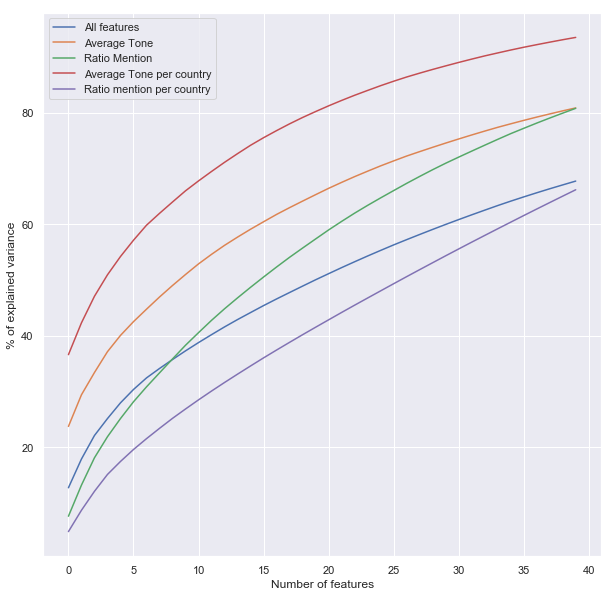

In [71]:
plt.plot(pca1.explained_variance_ratio_.cumsum()*100)
plt.plot(pca2.explained_variance_ratio_.cumsum()*100)
plt.plot(pca3.explained_variance_ratio_.cumsum()*100)
plt.plot(pca4.explained_variance_ratio_.cumsum()*100)
plt.plot(pca5.explained_variance_ratio_.cumsum()*100)

plt.xlabel('Number of features')
plt.ylabel('% of explained variance')
plt.legend(['All features', 'Average Tone', 'Ratio Mention', 'Average Tone per country', 'Ratio mention per country'])

We define 4 functions for the 4 clustering algorithm we will use: *KMean, DBSCAN, GMM and spectracl clustering*. It is a fully unsupervised learning since we don't have any data about the ground truth of the real cluster. The metric we choose to mesure our clustering is the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). 

Each function return the dataframe with the country labeled and the silhouette score. 


In [72]:
def KMean_clustering(n_cluster, data): 
    KMeans_1 = KMeans(n_clusters=n_cluster)
    KMeans_1.fit(data)
    label = KMeans_1.labels_
    df = pd.DataFrame(label, index=df_cleaning.index, columns=["Label"])
    return df, metrics.silhouette_score(data, label, metric='euclidean')

In [73]:
def DBSCAN_clustering(data, eps=5): 
    DBSCAN_1 = DBSCAN(eps = eps, min_samples=10)
    DBSCAN_1.fit(data)
    label = DBSCAN_1.labels_
    df = pd.DataFrame(label, index=df_cleaning.index, columns=["Label"])
    score = 0 if len(np.unique(label))<2 else metrics.silhouette_score(data, label, metric='euclidean')
    return df, score

In [74]:
def GMM_clustering(data, n_components= 2): 
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
    label = gmm.fit_predict(data)
    df = pd.DataFrame(label, index=df_cleaning.index, columns=["Label"])
    return df, metrics.silhouette_score(data, label, metric='euclidean')

In [75]:
def spectral_clustering(data, n_components= 2): 
    # Fit a Gaussian mixture with EM
    data2 = sklearn.metrics.pairwise.rbf_kernel(data, gamma=1/10000)
    SpCLu =  SpectralClustering(n_clusters=n_components, eigen_solver='arpack', affinity='precomputed')
    label = SpCLu.fit_predict(data2)
    df = pd.DataFrame(label, index=df_cleaning.index, columns=["Label"])
    return df, metrics.silhouette_score(data, label, metric='euclidean')

Here comes the core of the clustering process, for each dataset, for each algorithm and for each parameter (number of cluster or epsilon), the process is repeated 10 times.

In [76]:
# number of cluster to test
n_components_range = range(2, 8)
repetition = 10 

# Dictionnary to store the different result of the clustering per dataset
results_per_dataset_gmm = {}
results_per_dataset_kmean = {}
results_per_dataset_dbscan = {}
results_per_dataset_speclu = {}

# Dictionnary to store the different score of the clustering per dataset
score_per_dataset_gmm = {}
score_per_dataset_kmean = {}
score_per_dataset_dbscan = {}
score_per_dataset_speclu = {}


#Iterate over all dataset in the dictionnary
for name_dataset in dataset_to_cluster:
    data_to_cluster = dataset_to_cluster[name_dataset]
    print(name_dataset)

    # Interdistance bound used for thr DBSCAN
    max_distance = sklearn.metrics.euclidean_distances(data_to_cluster).max()
    min_distance = sklearn.metrics.euclidean_distances(data_to_cluster).min()
    
    #Array used to store the intermediate values 
    df_array_gmm = []
    df_array_kmean = []
    df_array_dbscan = []
    df_array_speclu = []
    score_array_gmm = []
    score_array_kmean = []
    score_array_dbscan = []
    score_array_speclu = []
    
    #Initlilization of the best score. The silhouette score range between -1 and 1
    best_score = -2
    
    # GMM
    # compute the label for different number of clusters
    for k in n_components_range:
        best_score = -2
        score_sum = 0
        
        # Multiple runs
        for i in range(0,repetition): 
            df, score = GMM_clustering(data_to_cluster, n_components=k)
            
            score_sum = score_sum + score
            
            #Keep the best score
            if(score>best_score):
                best_score = score
                best_df = df
        
        # Append the mean score and the label with the highest score
        df_array_gmm.append(best_df)
        score_array_gmm.append(score_sum/repetition)
    
    # KMEAN
    for k in n_components_range:
        best_score = -2
        score_sum = 0
        for i in range(0,repetition): 
            df, score = KMean_clustering(data=data_to_cluster, n_cluster=k)
            
            score_sum = score_sum + score
            if(score>best_score):
                best_score = score
                best_df = df
                
        df_array_kmean.append(best_df)
        score_array_kmean.append(score_sum/repetition)
    
    #SPECTRAL CLUSTERING
    for k in n_components_range:
        best_score = -2
        score_sum = 0
        for i in range(0,repetition): 
            df, score = spectral_clustering(data=data_to_cluster, n_components=k)
            score_sum = score_sum + score
            if(score>best_score):
                best_score = score
                best_df = df
                            
        df_array_speclu.append(best_df)
        score_array_speclu.append(score_sum/repetition)
        
    #DBSCAN
    # Range beteen the minnimal distance between the point and the maximal
    for k in np.linspace(min_distance+0.1, max_distance, 10):
        best_score = -2
        score_sum = 0
        for i in range(0,repetition): 
            df, score = DBSCAN_clustering(data=data_to_cluster, eps=k)
             
            score_sum = score_sum + score
            if(score>best_score):
                best_score = score
                best_df = df
                
        df_array_dbscan.append(best_df)
        score_array_dbscan.append(score_sum/repetition)
        
        
    results_per_dataset_gmm[name_dataset]= df_array_gmm
    results_per_dataset_kmean[name_dataset] = df_array_kmean
    results_per_dataset_dbscan[name_dataset] = df_array_dbscan
    results_per_dataset_speclu[name_dataset] = df_array_speclu
    
    score_per_dataset_gmm[name_dataset] = score_array_gmm
    score_per_dataset_kmean[name_dataset] = score_array_kmean
    score_per_dataset_dbscan[name_dataset] = score_array_dbscan
    score_per_dataset_speclu[name_dataset] = score_array_speclu

data_to_cluster
pca_s_df_cleaned_avgTone
pca_s_df_cleaned_ratioMention
pca_s_df_cleaned_avgTone_grouped_country
pca_s_df_cleaned_ratioMention_grouped_country
s_df_cleaned_avgTone_grouped_CAMEO
s_df_cleaned_ratioMention_grouped_CAMEO


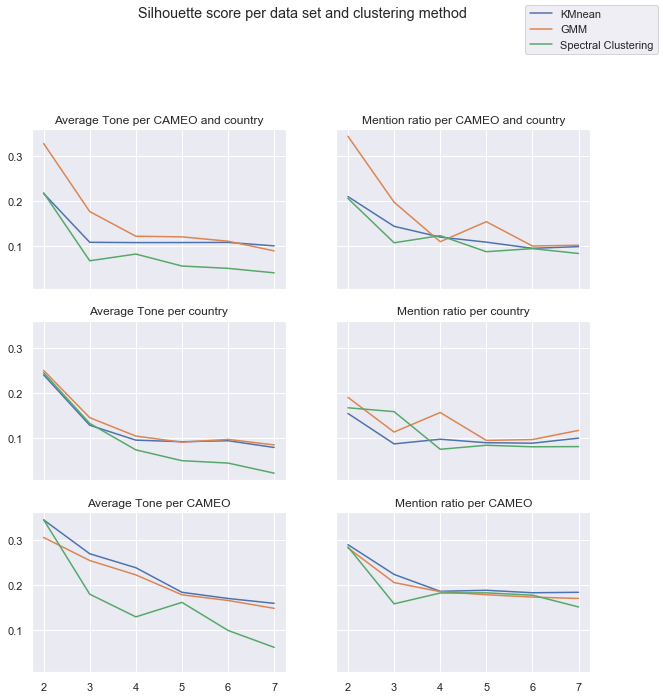

In [77]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
fig.suptitle('Silhouette score per data set and clustering method',  y=1.05)

col_plot = ['Average Tone per CAMEO and country', 'Mention ratio per CAMEO and country', \
            'Average Tone per country', 'Mention ratio per country',\
            'Average Tone per CAMEO', 'Mention ratio per CAMEO']
keys_to_plot = ['pca_s_df_cleaned_avgTone', 'pca_s_df_cleaned_ratioMention',\
                'pca_s_df_cleaned_avgTone_grouped_country', 'pca_s_df_cleaned_ratioMention_grouped_country',\
                's_df_cleaned_avgTone_grouped_CAMEO', 's_df_cleaned_ratioMention_grouped_CAMEO']

for axe, col, i in zip(axs.flat, col_plot, range(0,6)):
    axe.plot(range(2,8),score_per_dataset_kmean[keys_to_plot[i]])
    axe.plot(range(2,8),score_per_dataset_gmm[keys_to_plot[i]])
    axe.plot(range(2,8),score_per_dataset_speclu[keys_to_plot[i]])
    axe.set_title(col)
fig.legend(['KMnean','GMM', 'Spectral Clustering'])

As we can see, the results are not really promising. The silhouette score range from -1, bad clustering, to 1 for perfectly clustered datapoints. There isn't any algorithm which stands out, and in addition, they behave really poorly.
We didn't plot the DBSCAN because it was abble to create several clusters. 

We decided to use the spectral clustering, since it we think we have only a few clusters and the geomtry is non-flat.
We will visualize the results and use our common sens to interpret the results. 

In [78]:
world_map_cluster = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

In [79]:
def data_to_plot (df1):
    cluster_data = df1.rename(index=fips_to_country_dict)["Label"]
    cluster_data.index.values[cluster_data.index.values=='United States'] = 'United States of America'
    cluster_data.index.values[cluster_data.index.values=='Serbia'] = 'Republic of Serbia'
    cluster_data = cluster_data.to_dict()
    return cluster_data

In [184]:
world_map_with_cluster = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

# Defining a style function to color the map and the borders
style_func=lambda feature: {'fillColor': '#990033','color' : 'black','weight' : 2 }

 # Using a GeoJsonTooltip to display cantons' name when mouse is over them
tool=folium.features.GeoJsonTooltip(fields=['name'], aliases=['Country:'], sticky=True, \
                          style="font-family: Arial; color: black;", \
                         opacity=0.8, \
                        direction='top' \
                      )

# Load border information on the map
folium.TopoJson(world_borders,\
                object_path='objects.countries1',\
                style_function=style_func,\
               ) \
      .add_to(world_map_with_cluster)

This un friendly next cell is due to the fact that a for loop wasn't working:

In [185]:
name = 'data_to_cluster'
df1 = results_per_dataset_speclu[name][2]
cluster_data1 = data_to_plot(df1)

color_scale_cluster1 = LinearColormap(['yellow','red'], \
                                     vmin = min(cluster_data1.values()), \
                                     vmax = max(cluster_data1.values()), \
                                     caption='World seen from US'\
                                    )

name = 'pca_s_df_cleaned_avgTone'
df1 = results_per_dataset_speclu[name][2]
cluster_data2 = data_to_plot(df1)

color_scale_cluster2 = LinearColormap(['yellow','red'], \
                                     vmin = min(cluster_data2.values()), \
                                     vmax = max(cluster_data2.values()), \
                                     caption='World seen from other'\
                                    )
name = 'pca_s_df_cleaned_ratioMention'
df1 = results_per_dataset_speclu[name][2]
cluster_data3 = data_to_plot(df1)

color_scale_cluster3 = LinearColormap(['yellow','red'], \
                                     vmin = min(cluster_data3.values()), \
                                     vmax = max(cluster_data3.values()), \
                                     caption='World seen from other'\
                                    )
name = 'pca_s_df_cleaned_avgTone_grouped_country'
df1 = results_per_dataset_speclu[name][2]
cluster_data4 = data_to_plot(df1)

color_scale_cluster4 = LinearColormap(['yellow','red'], \
                                     vmin = min(cluster_data4.values()), \
                                     vmax = max(cluster_data4.values()), \
                                     caption='World seen from other'\
                                    )
name = 'pca_s_df_cleaned_ratioMention_grouped_country'
df1 = results_per_dataset_speclu[name][2]
cluster_data5 = data_to_plot(df1)

color_scale_cluster5 = LinearColormap(['yellow','red'], \
                                     vmin = min(cluster_data5.values()), \
                                     vmax = max(cluster_data5.values()), \
                                     caption='World seen from other'\
                                    )
name = 's_df_cleaned_avgTone_grouped_CAMEO'
df1 = results_per_dataset_speclu[name][2]
cluster_data6 = data_to_plot(df1)

color_scale_cluster6 = LinearColormap(['yellow','red'], \
                                     vmin = min(cluster_data6.values()), \
                                     vmax = max(cluster_data6.values()), \
                                     caption='World seen from other'\
                                    )
name = 's_df_cleaned_ratioMention_grouped_CAMEO'
df1 = results_per_dataset_speclu[name][2]
cluster_data7 = data_to_plot(df1)

color_scale_cluster7 = LinearColormap(['yellow','red'], \
                                     vmin = min(cluster_data7.values()), \
                                     vmax = max(cluster_data7.values()), \
                                     caption='World seen from other'\
                                    )


map_1 = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, cluster_data1, color_scale_cluster1),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'All data',
    )

map_2 = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, cluster_data2, color_scale_cluster2),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average Tone CAMEO/country',
    )

map_3 = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, cluster_data3, color_scale_cluster3),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Mention ratio CAMEO/country',
    )
map_4 = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, cluster_data4, color_scale_cluster4),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average tone country',
    )
map_5 = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, cluster_data5, color_scale_cluster5),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Mention ratio country',
    )
map_6 = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, cluster_data2, color_scale_cluster6),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average tone CAMEO',
    )
map_7 = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, cluster_data7, color_scale_cluster7),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Mention ratio CAMEO',
    )

world_map_with_cluster.add_child(map_1).add_child(map_2).add_child(map_3).add_child(map_4).add_child(map_5).add_child(map_6).add_child(map_7)
world_map_with_cluster.add_child(folium.map.LayerControl())

world_map_with_cluster


world_map_with_cluster.save('clustering_maps.html')
IFrame(src='clustering_maps.html', width=900, height=700)


In case you don't see the map please open `clustering_maps.html` to see it in your browser.

# Link between media content and well-being of the inhabitants

##### 1. Does global tone related to a country's events reflects its happiness level ?

The following query was submitted to Google BigQuery, in order to get the average MentionDocTone over all events happening in each country : 

SELECT ActionGeo_CountryCode as FIPS, AVG(MentionDocTone) as Average_tone

FROM gdelt-bq.gdeltv2.eventmentions as a

INNER JOIN (SELECT ActionGeo_CountryCode, GLOBALEVENTID FROM gdelt-bq.gdeltv2.events) as b

ON a.GLOBALEVENTID = b.GLOBALEVENTID

WHERE MentionType=1

GROUP BY ActionGeo_CountryCode 

Then we load the resulting table :

In [85]:
averageTone_locEvent = pd.read_csv('Data/AverageTone_LocEvent.csv')
averageTone_locEvent.head()

,FIPS,Average_tone
0,TU,-3.275389
1,SC,0.995833
2,PK,-3.806824
3,QA,-1.615441
4,CR,-1.917010


We load the table containing the Happiness Score per country, obtained from the World Happiness Report (2018).

In [86]:
happinessData = pd.read_excel('Data/HappinessData.xls', sheet_name = 'Figure2.2', usecols="A,B")

# Renaming certain countries for uniformity reasons
happinessData.loc[happinessData['Country']=='Congo (Brazzaville)', 'Country'] = 'Republic of the Congo'
happinessData.loc[happinessData['Country']=='Congo (Kinshasa)', 'Country'] = 'Democratic Republic of the Congo'
    
happinessData= happinessData.merge(FIPS_codes, left_on='Country', right_on='Country') # merging with FIPS_codes in order to make the link with country names
happinessData.head()

,Country,Happiness score,FIPS
0,Finland,7.6321,FI
1,Norway,7.5937,NO
2,Denmark,7.5553,DA
3,Iceland,7.4952,IC
4,Switzerland,7.4873,SZ


In [87]:
# Merging the table containing the average tone and the table containing the happiness score
happiness_tone_locEvent = averageTone_locEvent.merge(happinessData, left_on='FIPS', right_on='FIPS')
happiness_tone_locEvent.head()

,FIPS,Average_tone,Country,Happiness score
0,TU,-3.275389,Turkey,5.4825
1,PK,-3.806824,Pakistan,5.4725
2,QA,-1.615441,Qatar,6.3745
3,MK,-1.253623,Macedonia,5.1848
4,LE,-3.058331,Lebanon,5.1989


Now, let's plot the data and compute the correlation between these two variables :

/anaconda3/envs/adaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Happiness score of the country')

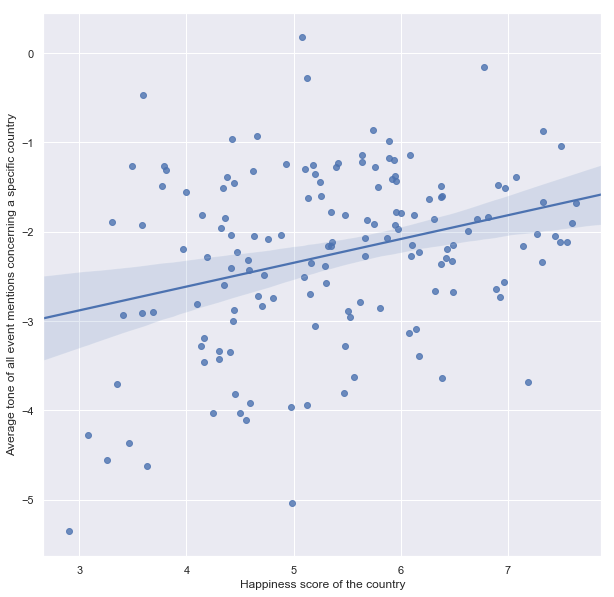

In [88]:
# we use seaborn regplot function to have both the scatter plot and a regression line on top
sn.set(rc={'figure.figsize':(10,10)})
sn.regplot('Happiness score', 'Average_tone', data=happiness_tone_locEvent)
plt.ylabel("Average tone of all event mentions concerning a specific country")
plt.xlabel("Happiness score of the country")

In [89]:
print('The Pearson correlation between Average Tone of event mentions concerning a specific country and the Happiness Score of this country is : ')
pearson_coef = happiness_tone_locEvent['Happiness score'].corr(happiness_tone_locEvent['Average_tone'])
print(pearson_coef)

The Pearson correlation between Average Tone of event mentions concerning a specific country and the Happiness Score of this country is : 
0.3057311727027529


We also apply bootstrapping on the Pearson Correlation statistic in order to be more confident with the result :

0.29231167099603916


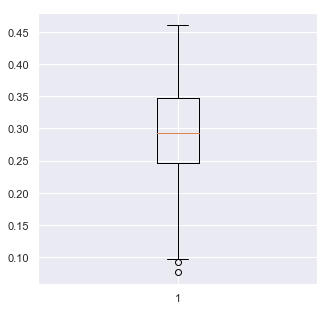

In [90]:
number_of_samples = 200

pearson_coefs_happinessAvgTone, ci_happinessAvgTone = bootstrapping(happiness_tone_locEvent, \
                                                                   number_of_samples, \
                                                                   features=['Happiness score', \
                                                                             'Average_tone'] \
                                                               )


sn.set(rc={'figure.figsize':(5,5)})

plt.boxplot(pearson_coefs_happinessAvgTone, \
              conf_intervals=[ci_happinessAvgTone], \
               manage_xticks = True \
             )

print(np.median(pearson_coefs_happinessAvgTone))

#### 2. Is there a link between media tone from a country sources and Happiness level ?

The following query was submitted to Google BigQuery, in order to get the average MentionDocTone over all sources of each country : 

SELECT FIPS, AVG(MentionDocTone) as AverageTone

FROM gdelt-bq.gdeltv2.eventmentions

INNER JOIN gdelt-bq.extra.sourcesbycountry

ON MentionSourceName=Domain

GROUP BY FIPS 

Then we load the resulting table :

In [91]:
averageTone_locSource = pd.read_csv('Data/avgToneBySourceLocation_table.csv')
averageTone_locSource.head()

,FIPS,AverageTone
0,IT,-1.226632
1,WA,-2.156439
2,CM,-2.944971
3,ML,-1.462604
4,MG,-0.242109


In [92]:
# Merging the table containing the average tone and the table containing the happiness score
happiness_locSource = averageTone_locSource.merge(happinessData, left_on='FIPS', right_on='FIPS')
happiness_locSource.head()

,FIPS,AverageTone,Country,Happiness score
0,IT,-1.226632,Italy,6.0004
1,WA,-2.156439,Namibia,4.4413
2,CM,-2.944971,Cameroon,4.9753
3,ML,-1.462604,Mali,4.4470
4,MG,-0.242109,Mongolia,5.1246


Now we plot the data and compute the correlation between both variables.

Text(0.5, 0, 'Happiness score of the country')

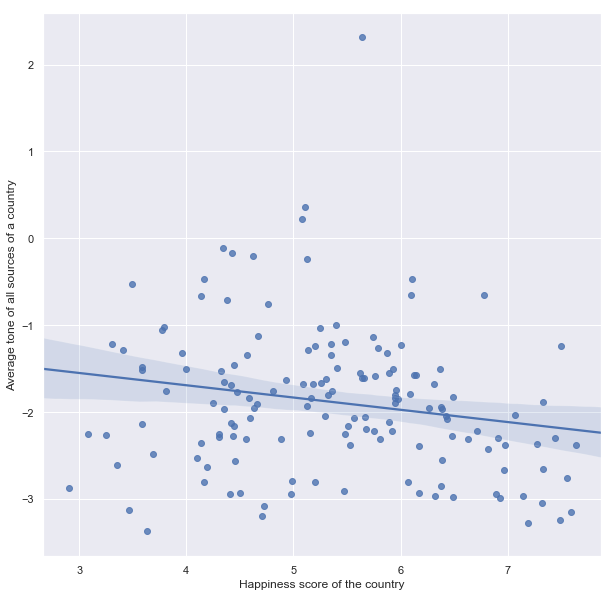

In [93]:
# we use seaborn regplot function to have both the scatter plot and a regression line on top
sn.set(rc={'figure.figsize':(10,10)})
sn.regplot('Happiness score', 'AverageTone', data=happiness_locSource)
plt.ylabel("Average tone of all sources of a country")
plt.xlabel("Happiness score of the country")

In [94]:
print('The Pearson correlation between Average Tone of all sources of a country and the Happiness Score of this country is : ')
pearson_coef = happiness_locSource['Happiness score'].corr(happiness_locSource['AverageTone'])
print(pearson_coef)

The Pearson correlation between Average Tone of all sources of a country and the Happiness Score of this country is : 
-0.19210691201771002


We also apply bootstrapping on the Pearson Correlation statistic in order to be more confident with the result :

-0.2006762857206809


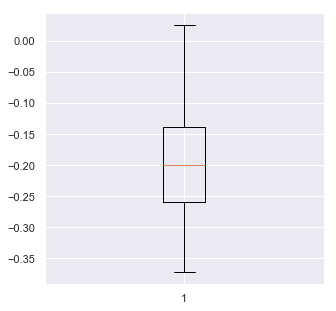

In [95]:
number_of_samples = 200

pearson_coefs_happinessAvgToneSource, ci_happinessAvgToneSource = bootstrapping(happiness_locSource, \
                                                                   number_of_samples, \
                                                                   features=['Happiness score', \
                                                                             'AverageTone'] \
                                                               )
sn.set(rc={'figure.figsize':(5,5)})

plt.boxplot(pearson_coefs_happinessAvgToneSource, \
              conf_intervals=[ci_happinessAvgToneSource], \
               manage_xticks = True \
             )

print(np.median(pearson_coefs_happinessAvgToneSource))

#### 3. Is there a link between the average Goldstein Scale value of all events happening in a country and its happiness score ?

The following query was submitted to Google BigQuery, in order to get the average GoldsteinScale over all events happening in each country : 

SELECT ActionGeo_CountryCode as FIPS, AVG(GoldsteinScale) AS GoldsteinScale

FROM gdelt-bq.gdeltv2.events

GROUP BY ActionGeo_CountryCode

Then we load the resulting table :

In [96]:
GoldsteinScale = pd.read_csv('Data/GoldsteinScale_fullRange.csv')\
    .merge(FIPS_codes, left_on='FIPS', right_on='FIPS')
GoldsteinScale.head()

,FIPS,GoldsteinScale,Country
0,CQ,1.515194,Northern Mariana Islands
1,ER,0.883016,Eritrea
2,QA,1.566748,Qatar
3,RP,0.311488,Philippines
4,AO,1.535179,Angola


We plot on a World map, the average Goldstein Scale per country, in order to visualize the geographical repartition of this value.

In order to match Goldstein Scale values per country, to the delimited countries in the topojson file, we need to change the name of some countries, e.g. replace 'United States' by 'United States of America'.

In [97]:
# Changing some country names for more correspondance
GoldsteinScale.loc[GoldsteinScale['Country']=='United States', 'Country'] = 'United States of America'
GoldsteinScale.loc[GoldsteinScale['Country']=='Serbia', 'Country'] = 'Republic of Serbia'
GoldsteinScale.loc[GoldsteinScale['Country']=='Tanzania', 'Country'] = 'United Republic of Tanzania'
GoldsteinScale.loc[GoldsteinScale['Country']=='Guinea-Bissau', 'Country'] = 'Guinea Bissau'
GoldsteinScale.loc[GoldsteinScale['Country']=='Bahamas', 'Country'] = 'The Bahamas'

print(GoldsteinScale['GoldsteinScale'].describe())

# Converting GoldsteinScale values into a dictionnary (necessary to create the map)
GoldsteinScale_dict = GoldsteinScale.set_index('Country')['GoldsteinScale'].to_dict()

count    238.000000
mean       0.944152
std        0.617748
min       -1.570356
25%        0.673953
50%        1.020962
75%        1.279100
max        2.481627
Name: GoldsteinScale, dtype: float64


In [186]:
Goldstein_map = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

# Defining a style function to color the map and the borders
style_func=lambda feature: {'fillColor': '#990033','color' : 'black','weight' : 2 }

# Using a GeoJsonTooltip to display country name when mouse is over them
tool=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'], sticky=True, \
                           style="font-family: Arial; color: black;", \
                           opacity=0.8, \
                           direction='top' \
                          )

# Load border information on the map
folium.TopoJson(world_borders,\
                object_path='objects.countries1',\
                style_function=style_func,\
                tooltip=tool, \
                overlay=False \
               ) \
      .add_to(Goldstein_map)

color_scale_Goldstein = LinearColormap(['red','blue'], \
                                     vmin = min(GoldsteinScale_dict.values()), \
                                     vmax = max(GoldsteinScale_dict.values()) \
                                    )

# Adding Goldstein Scale values on the map
folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, GoldsteinScale_dict, color_scale_Goldstein),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average Goldstein Scale',
    ).add_to(Goldstein_map)

color_scale_Goldstein.caption = 'Average Goldstein Scale per country (full date range)'
Goldstein_map.add_child(color_scale_Goldstein)
folium.LayerControl().add_to(Goldstein_map)
Goldstein_map


Goldstein_map.save('AverageGoldsteinScale.html')
IFrame(src='AverageGoldsteinScale.html', width=900, height=700)


In case you don't see the map please open `AverageGoldsteinScale.html` to see it in your browser.

In [99]:
# Merging with the table containing the happiness score
happinessData_clean = happinessData.drop('Country', axis=1)

happiness_GoldsteinScale = GoldsteinScale.merge(happinessData_clean, left_on='FIPS', right_on='FIPS')
happiness_GoldsteinScale.head()

,FIPS,GoldsteinScale,Country,Happiness score
0,QA,1.566748,Qatar,6.3745
1,RP,0.311488,Philippines,5.5241
2,AO,1.535179,Angola,3.7948
3,PM,1.005327,Panama,6.4300
4,PE,1.046938,Peru,5.6632


We plot the data repartition between Goldstein Scale and happiness score variables. Then we compute the correlation and use some bootstrapping in order to be more confident with the result:

Text(0.5, 0, 'Happiness score of the country')

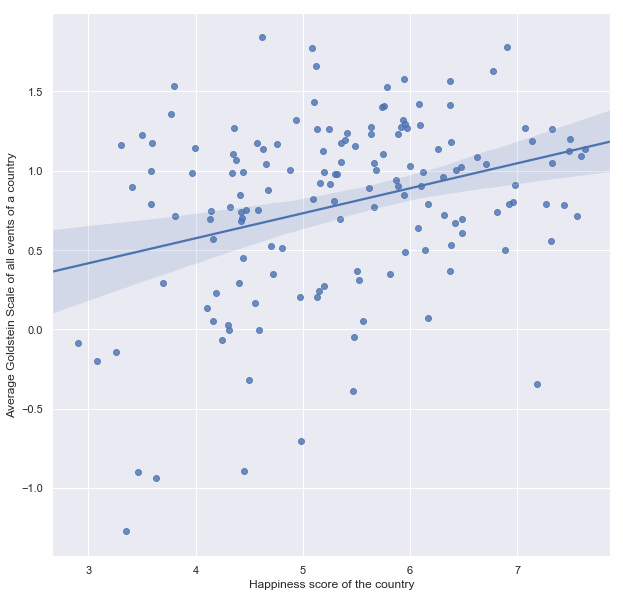

In [100]:
# we use seaborn regplot function to have both the scatter plot and a regression line on top
sn.set(rc={'figure.figsize':(10,10)})
sn.regplot('Happiness score', 'GoldsteinScale', data=happiness_GoldsteinScale)
plt.ylabel("Average Goldstein Scale of all events of a country")
plt.xlabel("Happiness score of the country")

In [101]:
print('The Pearson correlation between Average Goldstein Scale of all events of a country and the Happiness Score of this country is : ')
pearson_coef = happiness_GoldsteinScale['Happiness score'].corr(happiness_GoldsteinScale['GoldsteinScale'])
print(pearson_coef)

The Pearson correlation between Average Goldstein Scale of all events of a country and the Happiness Score of this country is : 
0.3148187086716634


0.3234622336175865


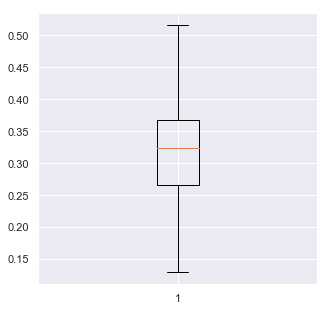

In [102]:
# Bootstrapping to get a more confident correlation statistics
number_of_samples = 200

pearson_coefs_happinessGoldstein, ci_happinessGoldstein = bootstrapping(happiness_GoldsteinScale, \
                                                                   number_of_samples, \
                                                                   features=['Happiness score', \
                                                                             'GoldsteinScale'] \
                                                               )
sn.set(rc={'figure.figsize':(5,5)})
plt.boxplot(pearson_coefs_happinessGoldstein, \
              conf_intervals=[ci_happinessGoldstein], \
               manage_xticks = True \
             )


print(np.median(pearson_coefs_happinessGoldstein))

<Figure size 7200x7200 with 0 Axes>

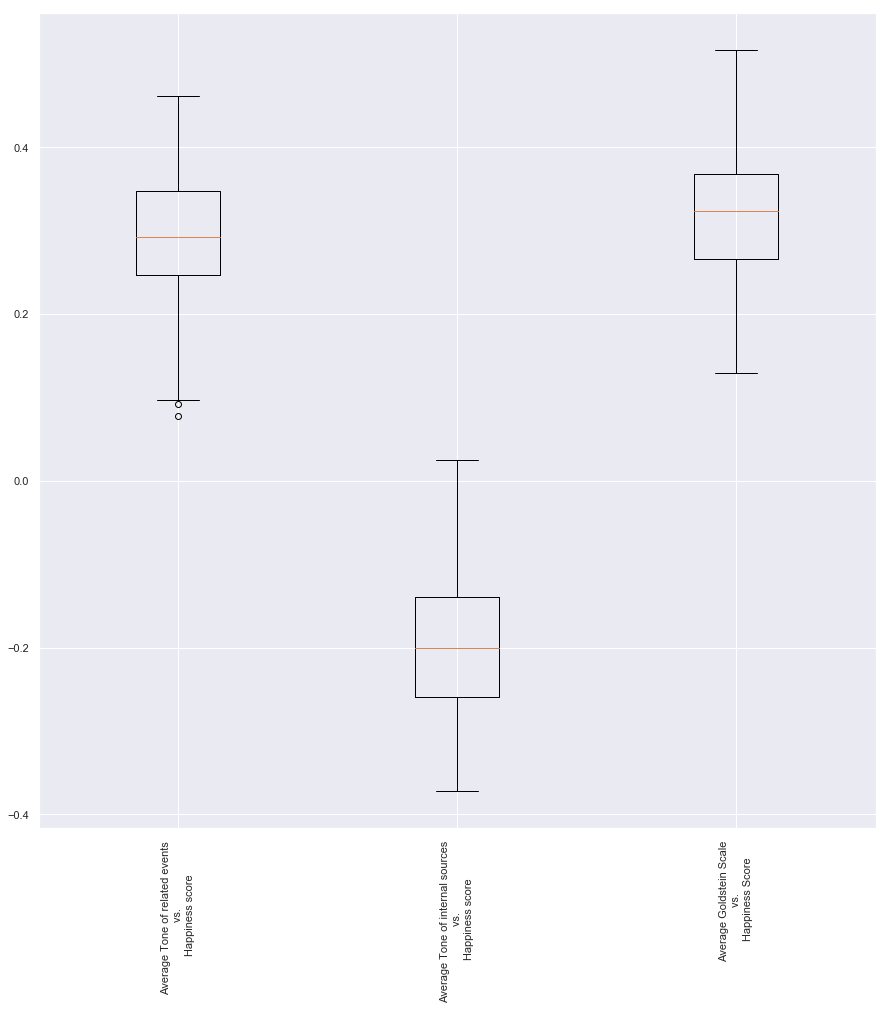

<Figure size 7200x7200 with 0 Axes>

In [196]:
# FIGURE WITH ALL THE BOXPLOTS OF THIS PART

_=plt.boxplot([pearson_coefs_happinessAvgTone, pearson_coefs_happinessAvgToneSource, pearson_coefs_happinessGoldstein], \
              conf_intervals=[ci_happinessAvgTone, ci_happinessAvgToneSource, ci_happinessGoldstein], \
              manage_xticks = True \
             )


x = [1, 2, 3]
labels=["Average Tone of related events \n vs.\n Happiness score", "Average Tone of internal sources \n vs.\n Happiness score"\
       ,"Average Goldstein Scale \n vs. \n Happiness Score"]
plt.xticks(x, labels, rotation='vertical')
plt.grid(True)
plt.savefig('boxplots_happiness.png', bbox_inches='tight') 
plt.figure(figsize=(100,100))

# Link between media content and political background of a country

#### 1. Correlation between Democratic quality and average tone

First, we are interested in the link between the Democratic Quality score of a country, and the average tone of its media sources. Concerning the average tone, we use the table averageTone_locSource created previously. The Democratic Quality score is obtained from Wikipedia's Democracy Index dataset. These data collected from the Economist also classify the Democratic Quality score into 4 different categories, as follows :

In [104]:
DemocraticQualityData = pd.read_csv('Data/democracy_index.csv', usecols=['Country', 'Score', 'Category'])\
    .rename(index=str, columns={'Score':'Democratic Quality'})\
    .merge(FIPS_codes, left_on='Country', right_on='Country') # Merging with the FIPS codes because it is originally based on country names

DemocraticQualityData.head()

,Country,Democratic Quality,Category,FIPS
0,Norway,9.87,Full democracy,NO
1,Iceland,9.58,Full democracy,IC
2,Sweden,9.39,Full democracy,SW
3,New Zealand,9.26,Full democracy,NZ
4,Denmark,9.22,Full democracy,DA


In [105]:
# Merging with the Average Tone data
DemocraticQuality_AvgTone_locSource = DemocraticQualityData.merge(averageTone_locSource, left_on='FIPS', right_on='FIPS')
DemocraticQuality_AvgTone_locSource.head()

,Country,Democratic Quality,Category,FIPS,AverageTone
0,Norway,9.87,Full democracy,NO,-3.147385
1,Iceland,9.58,Full democracy,IC,-1.240504
2,Sweden,9.39,Full democracy,SW,-3.043232
3,New Zealand,9.26,Full democracy,NZ,-1.889038
4,Denmark,9.22,Full democracy,DA,-2.763428


Text(0.5, 0, 'Democratic Quality score of the country')

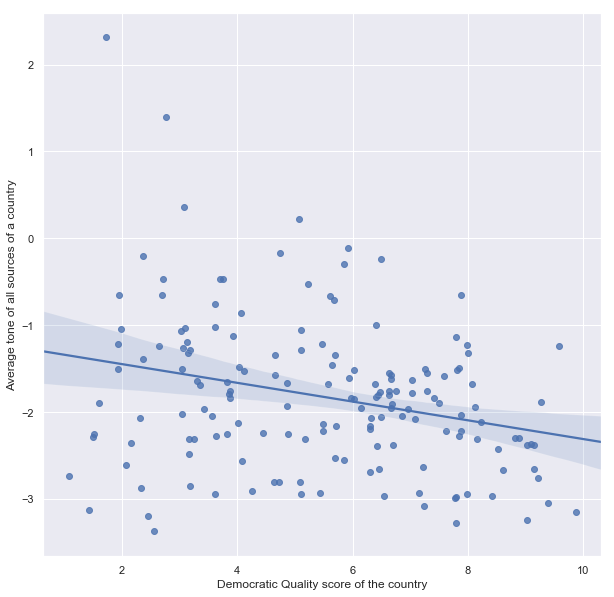

In [106]:
# we use seaborn regplot function to have both the scatter plot and a regression line on top
sn.set(rc={'figure.figsize':(10,10)})
sn.regplot('Democratic Quality', 'AverageTone', data=DemocraticQuality_AvgTone_locSource)
plt.ylabel("Average tone of all sources of a country")
plt.xlabel("Democratic Quality score of the country")

In [107]:
print('The Pearson correlation between Democratic Quality and Average Tone is : ')
print(DemocraticQuality_AvgTone_locSource['Democratic Quality'].corr(DemocraticQuality_AvgTone_locSource['AverageTone']))

The Pearson correlation between Democratic Quality and Average Tone is : 
-0.2699187830251109


We also apply bootstrapping on the Pearson Correlation statistic in order to be more confident with the result :

-0.2796847773220249


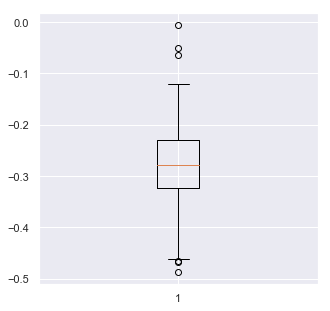

In [108]:
number_of_samples = 200

pearson_coefs_Demo_Tone, ci_Demo_Tone = bootstrapping(DemocraticQuality_AvgTone_locSource, \
                                                                   number_of_samples, \
                                                                   features=['Democratic Quality', \
                                                                             'AverageTone'] \
                                                               )

sn.set(rc={'figure.figsize':(5,5)})

plt.boxplot(pearson_coefs_Demo_Tone, \
              conf_intervals=[ci_Demo_Tone], \
               manage_xticks = True \
             )

print(np.median(pearson_coefs_Demo_Tone))

Now, dividing the countries depending on their Democratic category, we plot the average tone per category :

In [109]:
categories = ['Authoritarian', 'Hybrid regime', 'Flawed democracy', 'Full democracy']
mapping = {cat: i for i, cat in enumerate(categories)}
key = DemocraticQuality_AvgTone_locSource['Category'].map(mapping)

DemocraticQuality_AvgTone_locSource.iloc[key.argsort()]


DemocraticQuality_AvgTone_categories=DemocraticQuality_AvgTone_locSource.groupby('Category')['AverageTone']\
    .apply(np.mean)
DemocraticQuality_AvgTone_categories.head()

Category
Authoritarian      -1.557733
Flawed democracy   -1.969316
Full democracy     -2.357073
Hybrid regime      -1.693918
Name: AverageTone, dtype: float64

Text(0, 0.5, 'Average Tone')

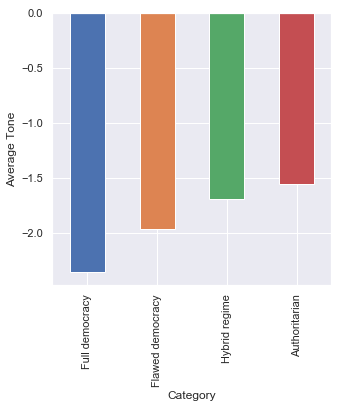

In [110]:
DemocraticQuality_AvgTone_categories.sort_values().plot.bar()
plt.ylabel('Average Tone')

We select some event categories that we find relevant : 'Fight', 'Exhibit Force Posture', 'Protest', 'Engage in diplomatic cooperation' and 'Engage in material cooperation'.

And we compute the average tone for each country sources, for each of these event types (using the EventRootCode parameter) : 

SELECT FIPS, EventRootCode, AVG(MentionDocTone) as AverageTone

FROM iron-stack-223417.ProjetGDELT.eventmentions_sources_table a

INNER JOIN (SELECT GLOBALEVENTID, EventRootCode

FROM gdelt-bq.gdeltv2.events

WHERE EventRootCode IN ('19', '15', '14', '05', '06')) b

ON a.GLOBALEVENTID=b.GLOBALEVENTID

GROUP BY FIPS, EventRootCode 

Then we load the resulting table :

In [111]:
averageTone_locSource_EventRootCode = pd.read_csv('Data/avgToneBySourceLocation_EventRootCode.csv',\
                                                  dtype={'EventRootCode':str})
averageTone_locSource_EventRootCode.head()

,FIPS,EventRootCode,AverageTone
0,SZ,19,-5.297849
1,RQ,05,-0.182663
2,KN,19,-4.212330
3,LH,05,0.477984
4,TD,15,-2.464236


In [112]:
# Merging with the democratic categories data : 
averageTone_democraticQuality_EventRootCode = DemocraticQualityData\
    .merge(averageTone_locSource_EventRootCode, left_on='FIPS', right_on='FIPS')
averageTone_democraticQuality_EventRootCode.head()

,Country,Democratic Quality,Category,FIPS,EventRootCode,AverageTone
0,Norway,9.87,Full democracy,NO,06,-1.867430
1,Norway,9.87,Full democracy,NO,14,-4.604183
2,Norway,9.87,Full democracy,NO,15,-3.198755
3,Norway,9.87,Full democracy,NO,19,-5.768208
4,Norway,9.87,Full democracy,NO,05,-1.115457


In [113]:
averageTone_democraticQuality_EventRootCode = averageTone_democraticQuality_EventRootCode.drop(averageTone_democraticQuality_EventRootCode[averageTone_democraticQuality_EventRootCode.EventRootCode == '--'].index)
averageTone_democraticQuality_EventRootCode = averageTone_democraticQuality_EventRootCode.drop(averageTone_democraticQuality_EventRootCode[averageTone_democraticQuality_EventRootCode.EventRootCode == 'X'].index)

averageTone_democraticQuality_EventRootCode['EventRootCode'] = averageTone_democraticQuality_EventRootCode['EventRootCode'].replace(CAMEO_translation_dict)

Then we plot the average for each of these Event categories, depending on the Democratic Category:

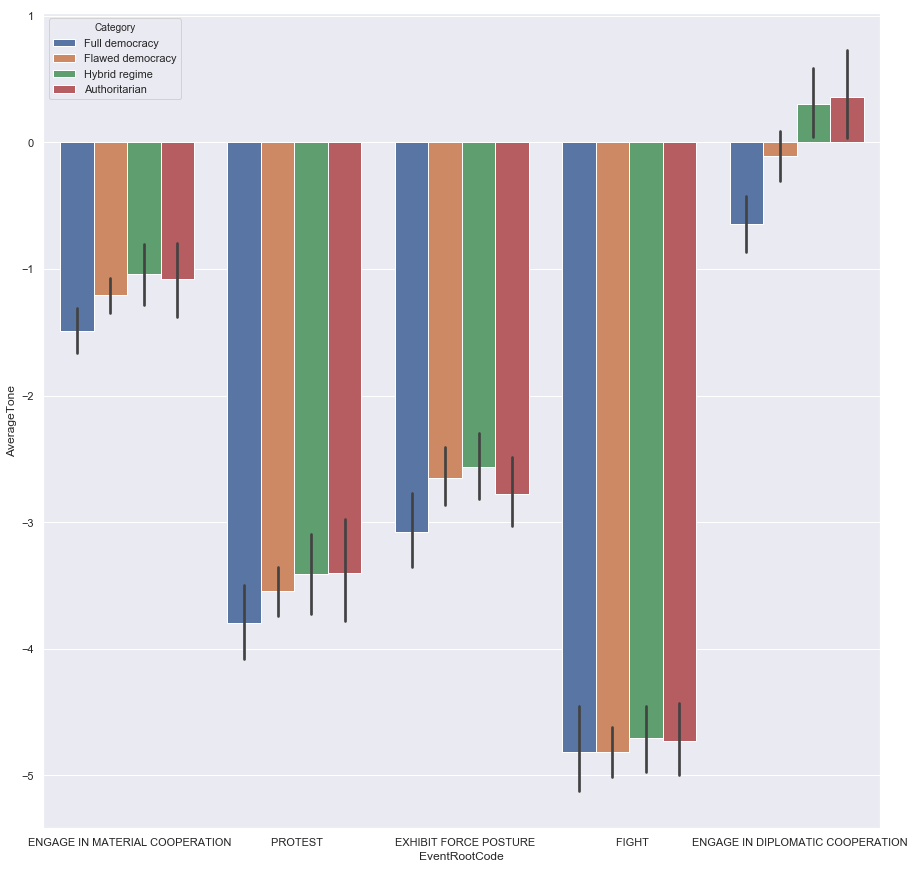

In [192]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
sn.barplot(x="EventRootCode", y="AverageTone", hue="Category", data=averageTone_democraticQuality_EventRootCode)


plt.savefig('eventCodeDemocracyCat.pdf', bbox_inches='tight')

#### 2. Difference in average tone between internal and external sources

Let's look at the difference in the way media sources talk about their origin country, as compared to how foreign media talk about it. Then, let's see if there is a correlation between this difference of vision and the democratic quality of the country.

We submitted a query on Google BigQuery in order to have the average MentionDocTone for all internal sources of a country, concerning events happening in this country :

SELECT ActionGeo_CountryCode as EventLocation, AVG(MentionDocTone) as AvgTone_Intern

FROM (SELECT MentionDocTone, FIPS, ActionGeo_CountryCode FROM iron-stack-223417.ProjetGDELT.eventmentions_sources_table as a JOIN gdelt-bq.gdeltv2.events as b 
ON a.GLOBALEVENTID=b.GLOBALEVENTID)

WHERE FIPS= ActionGeo_CountryCode GROUP BY ActionGeo_CountryCode

In [115]:
avgTone_internalSources = pd.read_csv('Data/avgTone_internalSources.csv')
avgTone_internalSources = avgTone_internalSources.merge(FIPS_codes, left_on='EventLocation', right_on='FIPS')\
    .drop('FIPS', axis=1)
avgTone_internalSources.head()

,EventLocation,AvgTone_Intern,Country
0,ZA,-0.822406,Zambia
1,LO,-1.806090,Slovakia
2,AL,-1.590928,Albania
3,CW,0.579648,Cook Islands
4,RO,-1.307122,Romania


We will plot the average tone of all internal sources on a map.

In order to match Average tone values per country, to the delimited countries in the topojson file, we need to change the name of some countries, e.g. replace 'United States' by 'United States of America'.

In [116]:
avgTone_internalSources.loc[avgTone_internalSources['Country']=='United States', 'Country'] = 'United States of America'
avgTone_internalSources.loc[avgTone_internalSources['Country']=='Serbia', 'Country'] = 'Republic of Serbia'
avgTone_internalSources.loc[avgTone_internalSources['Country']=='Tanzania', 'Country'] = 'United Republic of Tanzania'
avgTone_internalSources.loc[avgTone_internalSources['Country']=='Guinea-Bissau', 'Country'] = 'Guinea Bissau'
avgTone_internalSources.loc[avgTone_internalSources['Country']=='Bahamas', 'Country'] = 'The Bahamas'

print(avgTone_internalSources['AvgTone_Intern'].describe())

avgTone_internalSources_dict = avgTone_internalSources.set_index('Country')['AvgTone_Intern'].to_dict()

count    212.000000
mean      -0.937858
std        1.345638
min       -3.845790
25%       -1.795483
50%       -1.091014
75%       -0.432748
max        3.351737
Name: AvgTone_Intern, dtype: float64


Then we submitted a query on Google BigQuery in order to have the average MentionDocTone for all sources external to a country, concerning events happening in this country : 


SELECT ActionGeo_CountryCode as EventLocation, AVG(MentionDocTone) as AvgTone_Intern

FROM (SELECT MentionDocTone, FIPS, ActionGeo_CountryCode FROM iron-stack-223417.ProjetGDELT.eventmentions_sources_table as a JOIN gdelt-bq.gdeltv2.events as b 
ON a.GLOBALEVENTID=b.GLOBALEVENTID)

WHERE FIPS!= ActionGeo_CountryCode GROUP BY ActionGeo_CountryCode

In [117]:
avgTone_externalSources = pd.read_csv('Data/avgTone_externalSources.csv')
avgTone_externalSources = avgTone_externalSources.merge(FIPS_codes, left_on='EventLocation', right_on='FIPS')\
    .drop('FIPS', axis=1)
avgTone_externalSources.head()

,EventLocation,AvgTone_Extern,Country
0,NT,-0.675984,Netherlands Antilles
1,AU,-2.316602,Austria
2,MA,-1.708456,Madagascar
3,ZA,-1.990604,Zambia
4,VM,-1.913008,Vietnam


In [118]:
avgTone_externalSources.loc[avgTone_externalSources['Country']=='United States', 'Country'] = 'United States of America'
avgTone_externalSources.loc[avgTone_externalSources['Country']=='Serbia', 'Country'] = 'Republic of Serbia'
avgTone_externalSources.loc[avgTone_externalSources['Country']=='Tanzania', 'Country'] = 'United Republic of Tanzania'
avgTone_externalSources.loc[avgTone_externalSources['Country']=='Guinea-Bissau', 'Country'] = 'Guinea Bissau'
avgTone_externalSources.loc[avgTone_externalSources['Country']=='Bahamas', 'Country'] = 'The Bahamas'

print(avgTone_externalSources['AvgTone_Extern'].describe())
avgTone_externalSources_dict = avgTone_externalSources.set_index('Country')['AvgTone_Extern'].to_dict()

count    235.000000
mean      -2.312214
std        1.143217
min       -5.595630
25%       -2.981656
50%       -2.220734
75%       -1.543780
max        0.730550
Name: AvgTone_Extern, dtype: float64


In [187]:
world_map = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

# Defining a style function to color the map and the borders
style_func=lambda feature: {'fillColor': '#990033','color' : 'black','weight' : 2 }

# Using a GeoJsonTooltip to display country name when mouse is over them
tool=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'], sticky=True, \
                           style="font-family: Arial; color: black;", \
                           opacity=0.8, \
                           direction='top' \
                          )

# Load border information on the map
folium.TopoJson(world_borders,\
                object_path='objects.countries1',\
                style_function=style_func,\
                tooltip=tool, \
                overlay=False \
               ) \
      .add_to(world_map)

color_scale = LinearColormap(['red','blue'], \
                #vmin = min(avgTone_internalSources_dict.values()), \
                #vmax = max(avgTone_internalSources_dict.values()) \
                              vmin=-5.6, vmax= 3.4)

# FIRST MAP
folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, avgTone_internalSources_dict, color_scale),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average tone in internal medias',
    overlay=False
    ).add_to(world_map)

# SECOND MAP
folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, avgTone_externalSources_dict, color_scale),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average tone in external medias',
    show=False,
    overlay=False
    ).add_to(world_map)

color_scale.caption = 'Average tone concerning all country events'
world_map.add_child(color_scale)
folium.LayerControl().add_to(world_map)
world_map

world_map.save('IntervalExternalTone.html')
IFrame(src='IntervalExternalTone.html', width=900, height=700)


In case you don't see the map please open `IntervalExternalTone.html` to see it in your browser.

In [120]:
# We merge internal sources and external sources dataframes
avgTone_Difference = avgTone_externalSources\
    .merge(avgTone_internalSources, right_on=['Country','EventLocation'], left_on=['Country','EventLocation'])
avgTone_Difference.head()

,EventLocation,AvgTone_Extern,Country,AvgTone_Intern
0,AU,-2.316602,Austria,-1.471840
1,MA,-1.708456,Madagascar,-0.679975
2,ZA,-1.990604,Zambia,-0.822406
3,VM,-1.913008,Vietnam,1.141849
4,GR,-2.664889,Greece,-1.243538


In [121]:
# Now we compute the tone difference 
avgTone_Difference['Tone Difference'] = avgTone_Difference['AvgTone_Intern']\
    .subtract(avgTone_Difference['AvgTone_Extern'])\

print(avgTone_Difference['Tone Difference'].describe())
avgTone_Difference.head()

count    212.000000
mean       1.431066
std        1.333073
min       -2.186083
25%        0.512585
50%        1.208890
75%        2.059483
max        8.071409
Name: Tone Difference, dtype: float64


,EventLocation,AvgTone_Extern,Country,AvgTone_Intern,Tone Difference
0,AU,-2.316602,Austria,-1.471840,0.844762
1,MA,-1.708456,Madagascar,-0.679975,1.028481
2,ZA,-1.990604,Zambia,-0.822406,1.168197
3,VM,-1.913008,Vietnam,1.141849,3.054858
4,GR,-2.664889,Greece,-1.243538,1.421351


In [169]:
avgTone_Difference['Tone Difference'].sort_values(ascending=False).head()

93     8.071409
56     5.872180
71     4.779250
140    4.641612
90     4.423250
Name: Tone Difference, dtype: float64

In [172]:
# The maximum value is an outlier, thus we remove it before plotting
avgTone_Difference = avgTone_Difference.drop(93)

In [173]:
avgTone_Difference_dict = avgTone_Difference.set_index('Country')['Tone Difference'].to_dict()

world_map = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

# Defining a style function to color the map and the borders
style_func=lambda feature: {'fillColor': '#990033','color' : 'black','weight' : 2 }

# Using a GeoJsonTooltip to display country name when mouse is over them
tool=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'], sticky=True, \
                           style="font-family: Arial; color: black;", \
                           opacity=0.8, \
                           direction='top' \
                          )

# Load border information on the map
folium.TopoJson(world_borders,\
                object_path='objects.countries1',\
                style_function=style_func,\
                tooltip=tool, \
                overlay=False \
               ) \
      .add_to(world_map)

color_scale = LinearColormap(['yellow','red'], \
                vmin = min(avgTone_Difference_dict.values()), \
                vmax = max(avgTone_Difference_dict.values()))

# FIRST MAP
folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, avgTone_Difference_dict, color_scale),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average tone in internal medias'
    ).add_to(world_map)

# SECOND MAP
folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, avgTone_externalSources_dict, color_scale),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 1
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average tone in external medias',
    show=False
    ).add_to(world_map)

color_scale.caption = 'Average tone concerning all country events'
world_map.add_child(color_scale)
folium.LayerControl().add_to(world_map)
world_map


world_map.save('ToneDifference.html')
IFrame(src='ToneDifference.html', width=900, height=700)

In case you don't see the map please open `ToneDifference.html` to see it in your browser.

In [122]:
# We merge it with the democratic quality data, in order to see if there is a correlation
avgTone_Difference_DemocraticQuality = DemocraticQualityData.merge(avgTone_Difference, left_on=['FIPS','Country'], right_on=["EventLocation",'Country'])
avgTone_Difference_DemocraticQuality = avgTone_Difference_DemocraticQuality[['Country','Democratic Quality','Tone Difference']]
avgTone_Difference_DemocraticQuality.head()

,Country,Democratic Quality,Tone Difference
0,Norway,9.87,0.065328
1,Iceland,9.58,0.474964
2,Sweden,9.39,0.334264
3,New Zealand,9.26,0.727949
4,Denmark,9.22,0.311634


Text(0.5, 0, 'Democratic Quality score of the country')

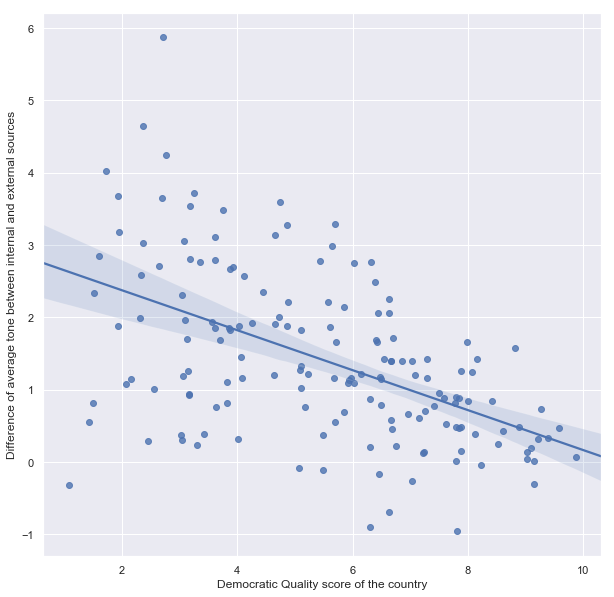

In [123]:
# we use seaborn regplot function to have both the scatter plot and a regression line on top
sn.set(rc={'figure.figsize':(10,10)})
sn.regplot('Democratic Quality', 'Tone Difference', data=avgTone_Difference_DemocraticQuality)
plt.ylabel("Difference of average tone between internal and external sources")
plt.xlabel("Democratic Quality score of the country")

In [124]:
print('The Pearson correlation between Democratic Quality and Average Tone difference is : ')
print(avgTone_Difference_DemocraticQuality['Democratic Quality']\
      .corr(avgTone_Difference_DemocraticQuality['Tone Difference']))

The Pearson correlation between Democratic Quality and Average Tone difference is : 
-0.5193395911902777



We also apply bootstrapping on the Pearson Correlation statistic in order to be more confident with the result :

-0.5203647326846961


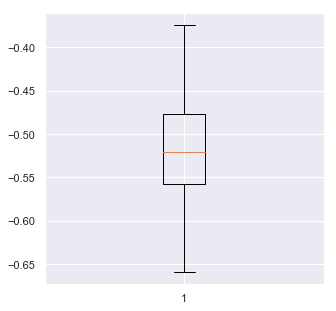

In [125]:
number_of_samples = 200

pearson_coefs_ToneDiff, ci_ToneDiff = bootstrapping(avgTone_Difference_DemocraticQuality, \
                                                                   number_of_samples, \
                                                                   features=['Democratic Quality', \
                                                                             'Tone Difference'] \
                                                               )
sn.set(rc={'figure.figsize':(5,5)})

plt.boxplot(pearson_coefs_ToneDiff, \
              conf_intervals=[ci_ToneDiff], \
               manage_xticks = True \
             )

print(np.median(pearson_coefs_ToneDiff))

<Figure size 7200x7200 with 0 Axes>

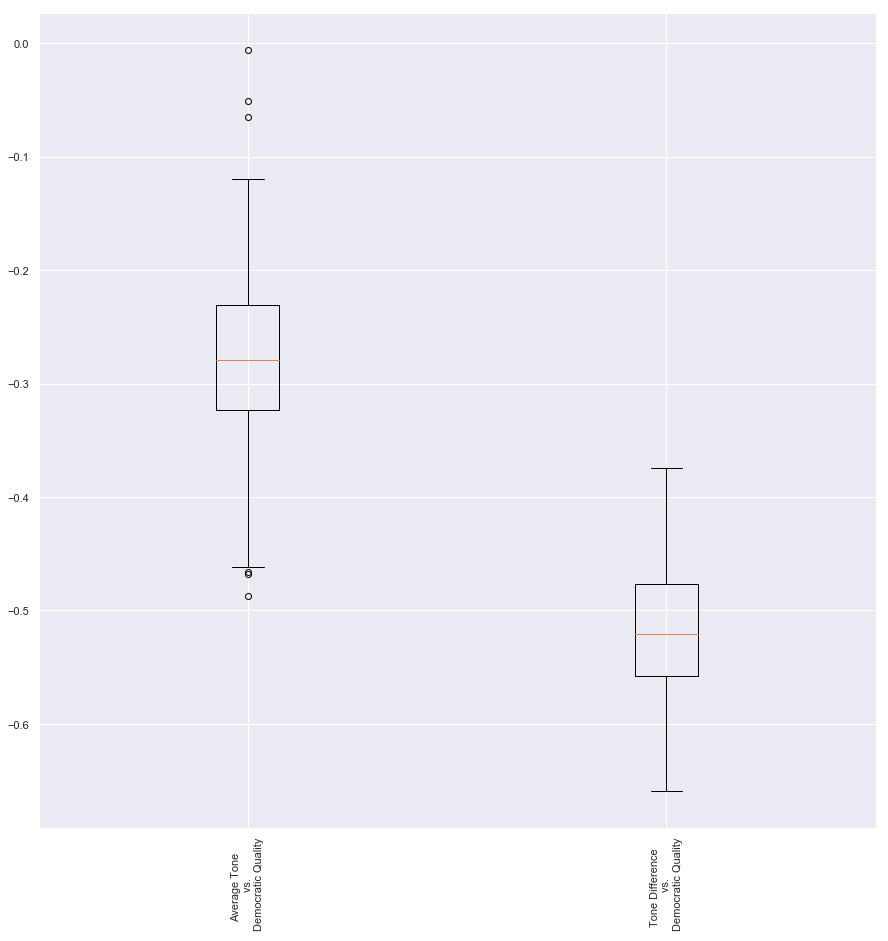

<Figure size 7200x7200 with 0 Axes>

In [195]:
# FIGURE CONTAINING ALL BOXPLOTS OF THIS PART

_=plt.boxplot([pearson_coefs_Demo_Tone, pearson_coefs_ToneDiff], \
              conf_intervals=[ci_Demo_Tone, ci_ToneDiff], \
              manage_xticks = True \
             )


x = [1, 2]
labels=["Average Tone \n vs.\n Democratic Quality", "Tone Difference \n vs.\n Democratic Quality"]
plt.xticks(x, labels, rotation='vertical')
plt.grid(True)
plt.savefig('boxplots_political.png', bbox_inches='tight') 
plt.figure(figsize=(100,100))

# Link between protest reflection on the media and well-being of the inhabitants and the political state of a country :

**Query on Google Big Query to create the mentions.csv dataframe :**

SELECT ActionGeo_CountryCode AS LocEvent, EventRootCode, COUNT(*) as NumberOfMentions 

FROM (

      SELECT GLOBALEVENTID AS GLOBALEVENTID_mentions
      
      FROM `gdelt-bq.gdeltv2.eventmentions` 
      
      WHERE MentionType =1      
      
      ) 
      
INNER JOIN `gdelt-bq.gdeltv2.events` ON `gdelt-bq.gdeltv2.events`.GLOBALEVENTID = GLOBALEVENTID_mentions 

GROUP BY ActionGeo_CountryCode, EventRootCode

**Loading the csv files into the notebook :**

In [127]:
mentions = pd.read_csv('Data/mentions.csv', dtype={'EventRootCode': np.str})

#Fips_codes will be useful further to get the country names from their respective fips codes
fips_codes = fips_codes[['fips','country']]

#From happiness_df, we will get the happiness scores for 156 countries
happinessData = pd.read_excel('Data/HappinessData.xls', sheet_name='Figure2.2')
happinessData = happinessData[['Country','Happiness score']]
happinessData.rename(index=str, columns={"Country": "country"}, inplace=True)

#Reading the world happiness report 2018
politics_df = pd.read_excel('Data/HappinessData.xls')

#Creating the confidence_df from the year, country and Confidence in national government features of the politics_df
confidence_df = politics_df[['year', 'country', 'Confidence in national government']]
confidence_df = confidence_df.dropna()
#The dataframe contains information for multiple years for each country, thus we just take in consideration the most recent information
confidence_df = confidence_df.sort_values('year', ascending=False) \
                             .groupby("country") \
                             .first()

#Creating the corruption_df from the year, country and Perceptions of corruption features of the politics_df
corruption_df = politics_df[['year', 'country', 'Perceptions of corruption']]
corruption_df = corruption_df.dropna()
#The dataframe contains information for multiple years for each country, thus we just take in consideration the most recent information
corruption_df = corruption_df.sort_values('year', ascending=False)\
                             .groupby("country").first()

#To construct, further, relations between the media and the political indicators, merging the corruption and confidence in gouvernment on each country
politics_df = corruption_df.merge(confidence_df, on='country', how='inner')
politics_df.rename(index=str, columns={"year_x": "year_corruption", "year_y": "year_confidence"}, inplace=True)

#Loading the The Economist's Democracy Index by Country(2017) 
democracy_index_df =  pd.read_csv('Data/democracy_index.csv')
democracy_index_df =  democracy_index_df[['Country', 'Score']]
democracy_index_df.rename(index=str, columns={"Country": "country", "Score": "Democratic Quality"}, inplace=True)

#Loading the informations about countries table 
country_info_df = pd.read_csv('Data/countryinfo.csv')

In [128]:
politics_df.head()

,year_corruption,Perceptions of corruption,year_confidence,Confidence in national government
country,,,,
Afghanistan,2017,0.954393,2017,0.261179
Albania,2017,0.876135,2017,0.457738
Angola,2014,0.834076,2014,0.572346
Argentina,2017,0.841052,2017,0.305430
Armenia,2017,0.864683,2017,0.246901


Let's observe our mentions dataframe coming from GDELTV2 and see if there are unwanted values for EventRootCode feature :

In [129]:
mentions['EventRootCode'].value_counts()

04    263
01    260
02    258
07    258
03    257
09    257
06    256
12    256
05    256
19    254
08    254
17    254
11    253
18    252
13    252
16    251
10    250
14    249
15    246
20    220
--     23
X       1
Name: EventRootCode, dtype: int64

"--" and "X" codes are not defined, thus dropping the rows corresponding to these codes:

In [130]:
mentions = (mentions[(mentions["EventRootCode"]!='X') & (mentions["EventRootCode"]!='--')])

**Creating the dataframe containing the information about the proportion of the number of protest news over the total number of news for each country :**

In [131]:
#Summing the number of mentions by country
mentions_by_country = mentions.groupby(['LocEvent'], as_index=False).sum()[['LocEvent','NumberOfMentions']]

#Summing the number of protest mentions by country
df = mentions.groupby(['LocEvent', 'EventRootCode'], as_index=False).sum()
protest_mentions_by_country = df[df['EventRootCode']=='14'].drop(columns=['EventRootCode']) \
                                                           .rename(index=str, \
                                                                   columns={"NumberOfMentions": "Number of protest mentions"},\
                                                                  )

#Creating the relative_mentions dataframe by merging the 2 dataframes created above on country FIPS Code
#and adding the column obtained by dividing the number or protest news by the number of news 
#for each country
relative_mentions = protest_mentions_by_country.merge(mentions_by_country, on='LocEvent', how='inner')
relative_mentions['Relative number of protest'] = relative_mentions['Number of protest mentions']/relative_mentions['NumberOfMentions']



In [132]:
relative_mentions.head()

,LocEvent,Number of protest mentions,NumberOfMentions,Relative number of protest
0,AA,203,47695,0.004256
1,AC,216,98264,0.002198
2,AE,11925,2934690,0.004063
3,AF,56085,9718130,0.005771
4,AG,15104,1456706,0.010369


**Adding the country names for each corresponding FIPS Code by merging with the dataframe containing the country names for FIPS Codes :**


In [133]:
relative_mentions = fips_codes.merge(relative_mentions, \
                                     left_on='fips', \
                                     right_on='LocEvent', \
                                     how='inner' \
                                    ) \
                              .drop(columns=['LocEvent'])

**Finally putting all the information together for each country :**

In [134]:
relative_mentions = relative_mentions.merge(happinessData, on='country', how='inner')
relative_mentions = relative_mentions.merge(politics_df, on='country', how='inner')
relative_mentions = relative_mentions.merge(democracy_index_df, on='country', how='inner')


In [135]:
relative_mentions.head()

,fips,country,Number of protest mentions,NumberOfMentions,Relative number of protest,Happiness score,year_corruption,Perceptions of corruption,year_confidence,Confidence in national government,Democratic Quality
0,AF,Afghanistan,56085,9718130,0.005771,3.6315,2017,0.954393,2017,0.261179,2.55
1,AL,Albania,62138,3367533,0.018452,4.5860,2017,0.876135,2017,0.457738,5.98
2,AM,Armenia,42372,2679371,0.015814,4.3206,2017,0.864683,2017,0.246901,4.11
3,AO,Angola,10950,1671962,0.006549,3.7948,2014,0.834076,2014,0.572346,3.62
4,AR,Argentina,49026,5527104,0.008870,6.3880,2017,0.841052,2017,0.305430,6.96


**Analysing the relation between the relative number of protest news and the indicators :**

In [136]:
corr = relative_mentions[['Relative number of protest', 'Confidence in national government', \
                          'Democratic Quality', 'Happiness score', 'Perceptions of corruption']].corr()
corr.style.background_gradient()

,Relative number of protest,Confidence in national government,Democratic Quality,Happiness score,Perceptions of corruption
Relative number of protest,1,-0.174152,-0.199675,-0.184985,0.225235
Confidence in national government,-0.174152,1,-0.270167,-0.180481,-0.446626
Democratic Quality,-0.199675,-0.270167,1,0.69385,-0.292589
Happiness score,-0.184985,-0.180481,0.69385,1,-0.447212
Perceptions of corruption,0.225235,-0.446626,-0.292589,-0.447212,1


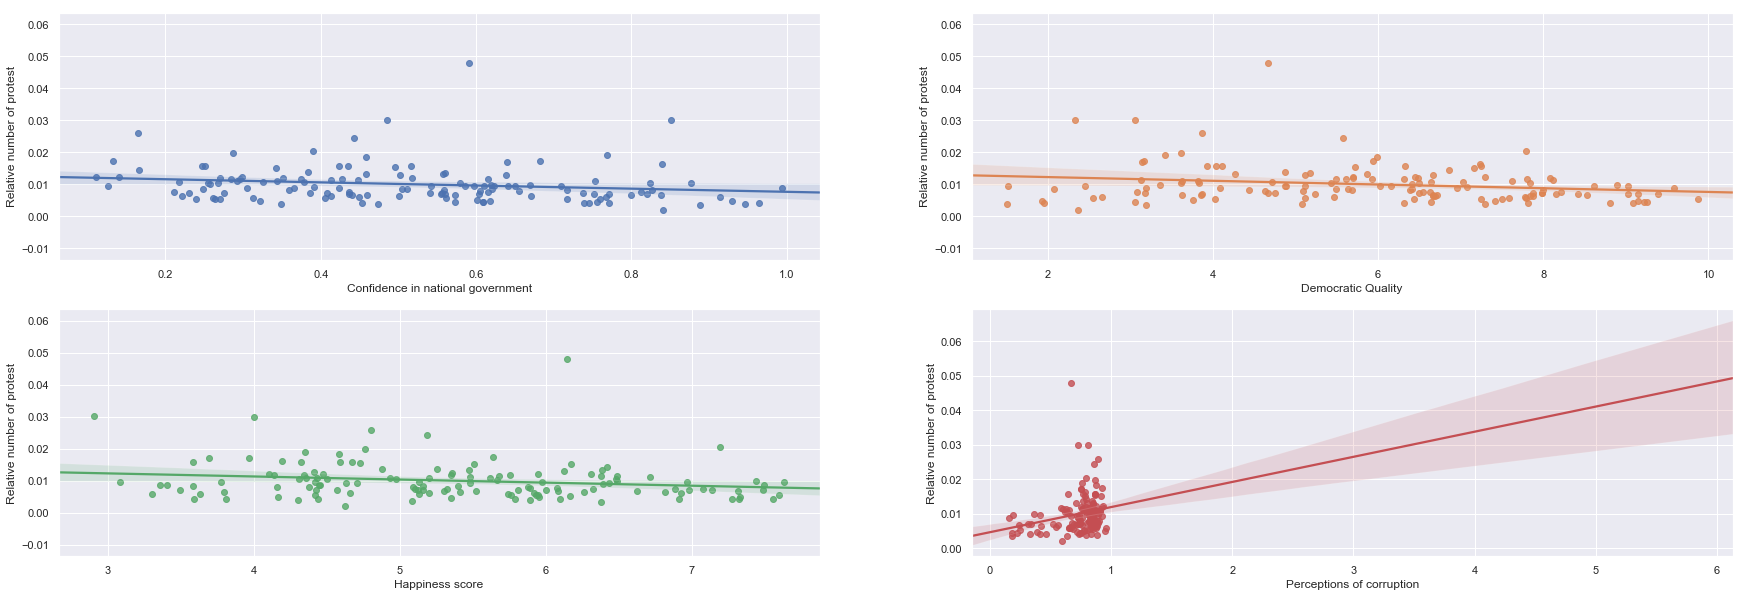

In [137]:
fig, axs = plt.subplots(2, 2, figsize=(30, 10))

#axs[0][0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Confidence in national government', 'Relative number of protest', data=relative_mentions, ax=axs[0][0])

#axs[0][1].set_title('Relation between population and number of protests ')
_=sn.regplot('Democratic Quality', 'Relative number of protest', data=relative_mentions, ax=axs[0][1])

#axs[1][0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Happiness score', 'Relative number of protest', data=relative_mentions, ax=axs[1][0])

#axs[1][1].set_title('Relation between population and number of protests ')
_=sn.regplot('Perceptions of corruption', 'Relative number of protest', data=relative_mentions, ax=axs[1][1])

For plotting the box plots for each relation, we bootstrapped and adopted the following methodology:

1.) We bootstrapped the pearson coefficient. To this end, we sampled 500 times the original data (each sample size is the length of the data). From each sample we calculated the pearson coefficient.

2.) We computed the mean of all the pearson coefficients calculated from each sample separetly.

3.) We converted the average pearson coefficient to Fisher's z' parameter with the following formula: 
$z'= \frac{log(\frac{1+r}{1-r})}{2}$

4.) $\textbf{CI}=[z'-t\cdot\sigma ; \ \ z'+t\cdot\sigma]$, where $t=1.96$ and $\sigma = \frac{1}{\sqrt{N-3}}$, where N is the sample size. $t=1.96$ given by the quantiles from the bootstrap distribution of the Student's t-test with 999 degrees of freedom for a 95% confidence interval.

5.) The final step is converting back the confidence interval limits to average pearson coefficient with the following formula:
$r = \frac{e^{2z'}-1}{e^{2z'}+1}$

In [138]:
def bootstrapping(data, number_of_sample, features, t=1.96):
    feature1 = features[0]
    feature2 = features[1]
    r = []
    sample_size = len(data)
    for i in range(number_of_sample):
        rnd_idx = np.random.randint(0, len(data), size=sample_size)
        data_sampled = data.iloc[rnd_idx]
        pearson_coeff = sp.stats.pearsonr(data_sampled[feature1], data_sampled[feature2])[0]
        # if the sample contains only identical values, the std is zero and pearsonr return NaN because of 
        # an impossible division by zero
        if not math.isnan(pearson_coeff):
            r.append(pearson_coeff)
     
    r_mean = np.mean(r) 
    z = np.log((1+r_mean)/(1-r_mean))/2
    std_err = 1/np.sqrt(sample_size-3)
    lower_z = z - std_err*t
    upper_z = z + std_err*t
    
    lower_r = (np.exp(2*lower_z)-1)/(np.exp(2*lower_z)+1)
    upper_r = (np.exp(2*upper_z)-1)/(np.exp(2*upper_z)+1)
    CI = (lower_r, upper_r)
    return r , CI

<Figure size 7200x7200 with 0 Axes>

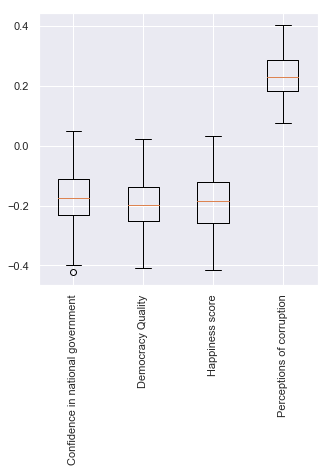

<Figure size 7200x7200 with 0 Axes>

In [139]:
number_of_sample = 200

confidence_in_gov_coefs, confidence_in_gov_coef_ci = bootstrapping(relative_mentions, \
                                                                   number_of_sample, \
                                                                   features=['Confidence in national government', \
                                                                             'Relative number of protest' \
                                                                            ] \
                                                                  )

democratic_quality_coefs, democratic_quality_coef_ci = bootstrapping(relative_mentions, \
                                                                     number_of_sample, \
                                                                     features=['Democratic Quality', \
                                                                               'Relative number of protest' \
                                                                              ] \
                                                                    )

happiness_coefs, happiness_coef_ci = bootstrapping(relative_mentions, \
                                                   number_of_sample, \
                                                   features=['Happiness score', \
                                                             'Relative number of protest' \
                                                            ] \
                                                  )

corruption_coefs, corruption_coef_ci = bootstrapping(relative_mentions, \
                                                     number_of_sample, \
                                                     features=['Perceptions of corruption', \
                                                               'Relative number of protest' \
                                                              ] \
                                                    )


_=plt.boxplot([confidence_in_gov_coefs, democratic_quality_coefs, happiness_coefs, corruption_coefs], \
              conf_intervals=[confidence_in_gov_coef_ci, democratic_quality_coef_ci, \
                              happiness_coef_ci, corruption_coef_ci \
                             ], \
               manage_xticks = True \
             )

x = [1, 2, 3, 4]
labels=["Confidence in national government", "Democracy Quality", "Happiness score", "Perceptions of corruption" ]
plt.xticks(x, labels, rotation='vertical')
plt.grid(True)
plt.figure(figsize=(100,100))


**Comparison between protest events and how they are seen in the media :**

**Query on Google Big Query to create the Protests.csv dataframe :**

SELECT COUNT(*), ActionGeo_CountryCode AS LocEvent

FROM `gdelt-bq.gdeltv2.events`

WHERE EventRootCode = '14'

GROUP BY ActionGeo_CountryCode

In [140]:
protests_df = pd.read_csv('Data/Protests.csv')
protests_df.rename(index=str, columns={"f0_": "Number of protests", 'LocEvent':'fips'}, inplace=True)
protests_df.head()

,Number of protests,fips
0,256,AN
1,31232,SA
2,1,SB
3,1,DQ
4,1,LQ


In [141]:
fips_codes = fips_codes[['fips','country']]
protests_df = fips_codes.merge(protests_df, \
                               on='fips', \
                               how='inner' \
                              ) \

In [142]:
protests_df.head()

,fips,country,Number of protests
0,AN,Andorra,256
1,AE,United Arab Emirates,5622
2,AF,Afghanistan,20784
3,AC,Antigua and Barbuda,169
4,AV,Anguilla,57


In [143]:
df = mentions.groupby(['LocEvent', 'EventRootCode'], as_index=False).sum()
protest_mentions_by_country = df[df['EventRootCode']=='14'].drop(columns=['EventRootCode']) \
                                                           .rename(index=str, \
                                                                   columns={"NumberOfMentions": "Number of protest mentions"},\
                                                                  )

In [144]:
protest_mentions_by_country.head()

,LocEvent,Number of protest mentions
13,AA,203
33,AC,216
52,AE,11925
72,AF,56085
92,AG,15104


In [145]:
merged = protests_df.merge(protest_mentions_by_country, left_on='fips', right_on='LocEvent', how='inner') \
                    .drop(columns=['LocEvent'])

In [146]:
merged.sort_values(by='Number of protests', ascending =False).head()

,fips,country,Number of protests,Number of protest mentions
216,US,United States,722163,2597240
95,IN,India,219592,408896
93,IS,Israel,152028,722064
179,RS,Russia,131837,332507
70,UK,United Kingdom,123079,312389


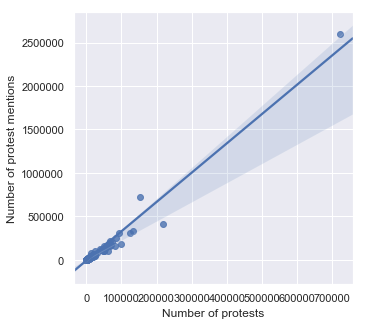

In [147]:
sn.regplot(x='Number of protests', y='Number of protest mentions', data=merged)

In [148]:
corr = merged[['Number of protests', 'Number of protest mentions']].corr()
corr.style.background_gradient()

,Number of protests,Number of protest mentions
Number of protests,1,0.982081
Number of protest mentions,0.982081,1


<Figure size 7200x7200 with 0 Axes>

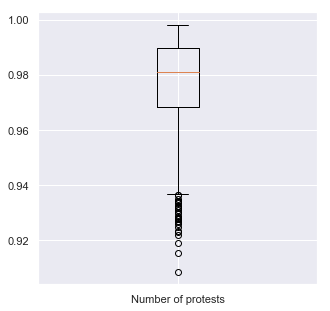

<Figure size 7200x7200 with 0 Axes>

In [149]:
number_of_sample = 300

merged_coefs, merged_coef_ci = bootstrapping(merged, \
                                             number_of_sample, \
                                             features=['Number of protests', \
                                                       'Number of protest mentions' \
                                                      ] \
                                            )

_=plt.boxplot([merged_coefs], \
              conf_intervals=[merged_coef_ci], \
              labels = ['Number of protests'] \
             )

plt.grid(True)
plt.figure(figsize=(100,100))


More the number of protests occuring in a country is increased, more the number of news about the protests country is increased. Thus the media reflects well the reality about the protests.

# Link between protests and well-being of the inhabitants and the political state of a country :

Instead of analysing the relation between the news of protests and the indicators, we can consider the protest events themselves and see on which indicator these events depend.

In [150]:
population = country_info_df[['fips', 'population']]
protests_df = protests_df.merge(population, on='fips', how='inner')
protests_df = protests_df.merge(democracy_index_df, on='country', how='inner')


,Number of protests,population,Democratic Quality
Number of protests,1,0.393874,0.138184
population,0.393874,1,-0.0100287
Democratic Quality,0.138184,-0.0100287,1


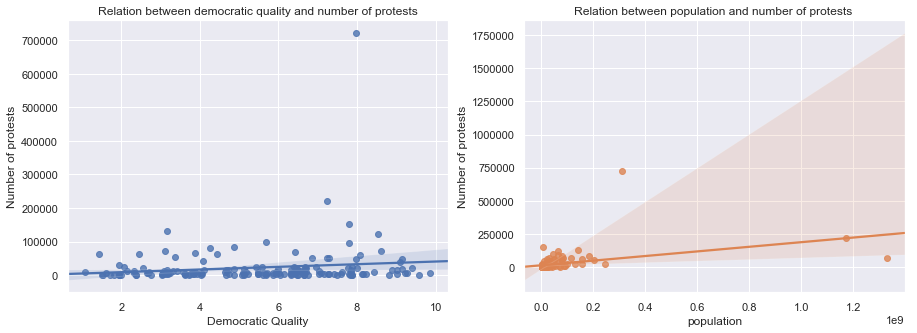

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=protests_df, ax=axs[1])

corr = protests_df[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()

<Figure size 7200x7200 with 0 Axes>

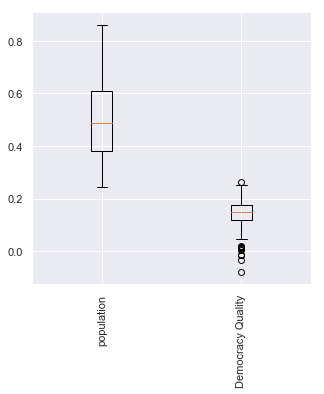

<Figure size 7200x7200 with 0 Axes>

In [152]:
number_of_sample = 200

population_coefs, population_coef_ci = bootstrapping(protests_df, \
                                                     number_of_sample, \
                                                     features=['population', \
                                                               'Number of protests' \
                                                              ] \
                                                    )

democratic_quality_coefs, democratic_quality_coef_ci = bootstrapping(protests_df, \
                                                                     number_of_sample, \
                                                                     features=['Democratic Quality', \
                                                                               'Number of protests' \
                                                                              ] \
                                                                    )

_=plt.boxplot([population_coefs, democratic_quality_coefs], \
              conf_intervals=[population_coef_ci, democratic_quality_coef_ci], \
              manage_xticks = True \
             )

x = [1, 2]
labels=["population", "Democracy Quality"]
plt.xticks(x, labels, rotation='vertical')
plt.grid(True)
plt.figure(figsize=(100,100))

We will now create 4 subsets among all the countries depending on their democratic qualities samely "Full democracy", "Flawed democracy", "Hybrid regime" and "Authoritarian" followed by an analysis on each categroy.

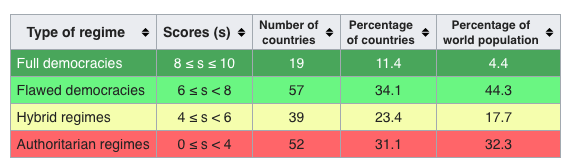

In [153]:
from IPython.display import Image
# Photos credit: https://en.wikipedia.org/wiki/Democracy_Index
Image('Data/Democracy_threshold.jpg', width=800,height=600)

**Authoritarian Countries :**

,Number of protests,population,Democratic Quality
Number of protests,1,0.421579,0.0224711
population,0.421579,1,0.0561642
Democratic Quality,0.0224711,0.0561642,1


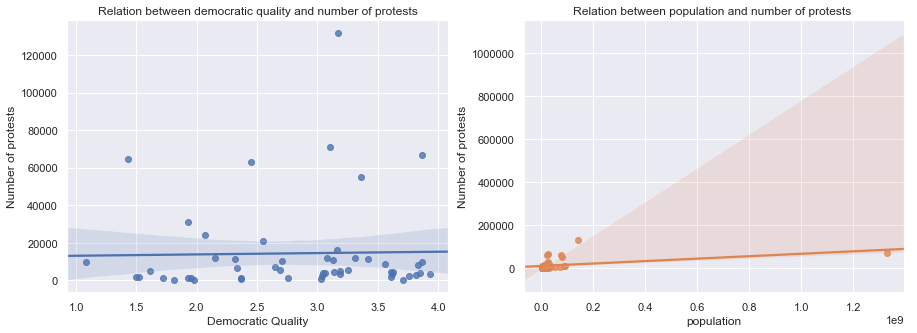

In [154]:
authoritarian_countries = protests_df[(protests_df['Democratic Quality']<4)]
                                   
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=authoritarian_countries, ax=axs[0])


axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=authoritarian_countries, ax=axs[1])


corr = authoritarian_countries[['Number of protests', 'population', 'Democratic Quality' ]].corr()
corr.style.background_gradient()

In [155]:
authoritarian_countries.sort_values(by='population', ascending=False).head()

,fips,country,Number of protests,population,Democratic Quality
30,CH,China,70954,1330044000,3.10
130,RS,Russia,131837,140702000,3.17
158,VM,Vietnam,11820,89571130,3.08
47,ET,Ethiopia,11324,88013491,3.42
44,EG,Egypt,54750,80471869,3.36


Regarding the plot giving the relation between the population and the number of protest events, the outlier on the right represents China.

**Hybrid Regime Countries :**

,Number of protests,population,Democratic Quality
Number of protests,1,0.655288,-0.17331
population,0.655288,1,-0.246636
Democratic Quality,-0.17331,-0.246636,1


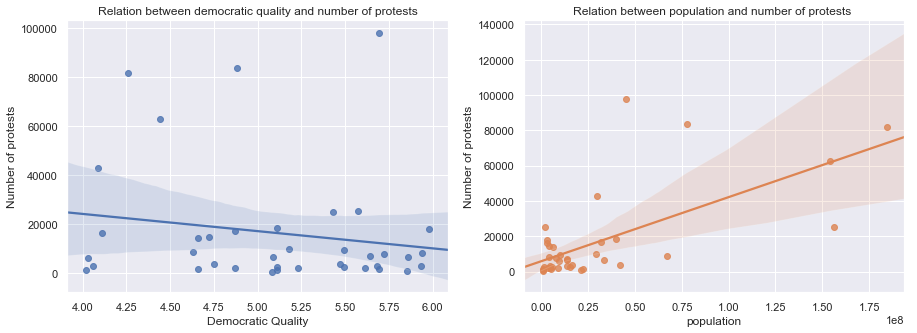

In [156]:
hybrid_countries = protests_df[(protests_df['Democratic Quality']>=4)&(protests_df['Democratic Quality']<6)]
                                    
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=hybrid_countries, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=hybrid_countries, ax=axs[1])

corr = hybrid_countries[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()

**Flawed Democracies :**

,Number of protests,population,Democratic Quality
Number of protests,1,0.473784,0.291752
population,0.473784,1,0.0847246
Democratic Quality,0.291752,0.0847246,1


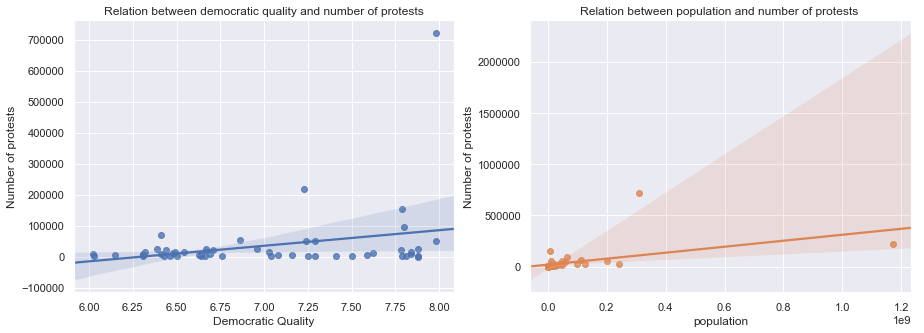

In [157]:
flawed_countries = protests_df[(protests_df['Democratic Quality']>=6)&(protests_df['Democratic Quality']<8)]
                                    
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=flawed_countries, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=flawed_countries, ax=axs[1])

corr = flawed_countries[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()

**Full Democracies :**

,Number of protests,population,Democratic Quality
Number of protests,1,0.857685,-0.20408
population,0.857685,1,-0.340479
Democratic Quality,-0.20408,-0.340479,1


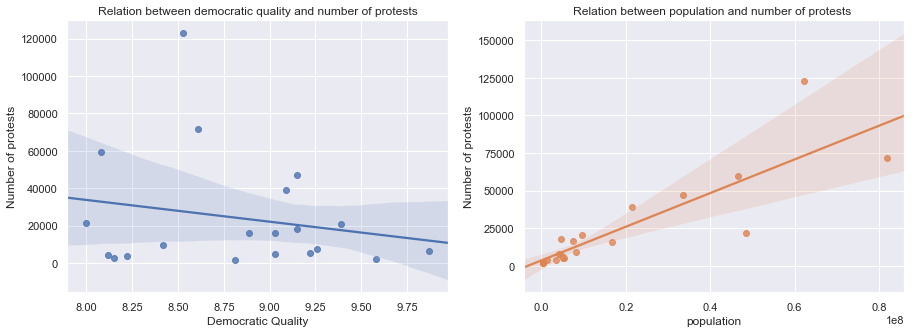

In [158]:
full_countries = protests_df[(protests_df['Democratic Quality']>=8)&(protests_df['Democratic Quality']<=10)]
                                    
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=full_countries, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=full_countries, ax=axs[1])

corr = full_countries[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()

<Figure size 7200x7200 with 0 Axes>

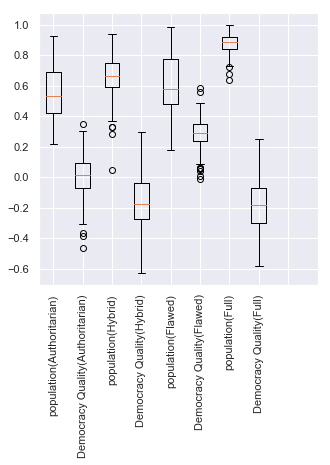

<Figure size 7200x7200 with 0 Axes>

In [159]:
number_of_sample = 200

#population_coefs, population_coef_ci = bootstrapping(protests_df, \
#                                                     number_of_sample, \
#                                                     features=['population', \
#                                                               'Number of protests' \
#                                                              ] \
#                                                    )

#democratic_quality_coefs, democratic_quality_coef_ci = bootstrapping(protests_df, \
#                                                                     number_of_sample, \
#                                                                     features=['Democratic Quality', \
#                                                                               'Number of protests' \
#                                                                              ] \
#                                                                    )


auth_population_coefs, auth_population_coef_ci = bootstrapping(authoritarian_countries, \
                                                               number_of_sample, \
                                                               features=['population', \
                                                                         'Number of protests' \
                                                                        ] \
                                                              )

auth_democratic_quality_coefs, auth_democratic_quality_coef_ci = bootstrapping(authoritarian_countries, \
                                                                               number_of_sample, \
                                                                               features=['Democratic Quality', \
                                                                                         'Number of protests' \
                                                                                        ] \
                                                                              )

hybrid_population_coefs, hybrid_population_coef_ci = bootstrapping(hybrid_countries, \
                                                                   number_of_sample, \
                                                                   features=['population', \
                                                                             'Number of protests' \
                                                                            ] \
                                                                  )

hybrid_democratic_quality_coefs, hybrid_democratic_quality_coef_ci = bootstrapping(hybrid_countries, \
                                                                                   number_of_sample, \
                                                                                   features=['Democratic Quality', \
                                                                                             'Number of protests' \
                                                                                            ] \
                                                                                  )

flawed_population_coefs, flawed_population_coef_ci = bootstrapping(flawed_countries, \
                                                                   number_of_sample, \
                                                                   features=['population', \
                                                                             'Number of protests' \
                                                                            ] \
                                                                  )

flawed_democratic_quality_coefs, flawed_democratic_quality_coef_ci = bootstrapping(flawed_countries, \
                                                                                   number_of_sample, \
                                                                                   features=['Democratic Quality', \
                                                                                             'Number of protests' \
                                                                                            ] \
                                                                                  )

full_population_coefs, full_population_coef_ci = bootstrapping(full_countries, \
                                                               number_of_sample, \
                                                               features=['population', \
                                                                         'Number of protests' \
                                                                        ] \
                                                              )

full_democratic_quality_coefs, full_democratic_quality_coef_ci = bootstrapping(full_countries, \
                                                                               number_of_sample, \
                                                                               features=['Democratic Quality', \
                                                                                         'Number of protests' \
                                                                                        ] \
                                                                              )


_=plt.boxplot([#population_coefs, democratic_quality_coefs, \
               auth_population_coefs, auth_democratic_quality_coefs, \
               hybrid_population_coefs, hybrid_democratic_quality_coefs, \
               flawed_population_coefs, flawed_democratic_quality_coefs, \
               full_population_coefs, full_democratic_quality_coefs \
              ], \
              conf_intervals=[#population_coef_ci, democratic_quality_coef_ci, \
                              auth_population_coef_ci, auth_democratic_quality_coef_ci, \
                              hybrid_population_coef_ci, hybrid_democratic_quality_coef_ci, \
                              flawed_population_coef_ci, flawed_democratic_quality_coef_ci, \
                              full_population_coef_ci, full_democratic_quality_coef_ci \
                             ], \
              manage_xticks = True \
             )

x = [1, 2,3,4,5,6,7,8,9,10]
labels=[#"population", "Democracy Quality", \
        "population(Authoritarian)", "Democracy Quality(Authoritarian)", \
        "population(Hybrid)", "Democracy Quality(Hybrid)", \
        "population(Flawed)", "Democracy Quality(Flawed)", \
        "population(Full)", "Democracy Quality(Full)", ]
plt.xticks(x, labels, rotation='vertical')
plt.grid(True)
plt.figure(figsize=(100,100))